# Neo Bank Churn Probability Prediction

###### Welcome to the Neo bank!
###### You have been hired as a data scientist, but the bank has huge problems. The competition gets harder and management has the feeling that churn is becoming a problem. Some initial experiments with simple behavioral rules have shown that customer behaviour can in fact be predicted, but they require you to do it!
###### Unfortunately data literacy is not as mature as in other companies, thus even a churn definition does not exist. It is all in your hands now!
###### It is your goal to create a churn definition, implement it and predict churn!
###### Your stakeholders set a very high priority to explainability and do not trust black box modelling, thus it has been decided that you can only deploy a single supervised model architecture: No blending, no stacking. At least the data scientist, whose role you are replacing, has been able to convince the stakeholders that model orchestration is not a black box before he left.
###### 
In this competition we expect participants to create a solution that uses a single model architecture per model type only. I.e. you may use Logistic Regression, Xgboost, Catboost or a neural network, but you are not allowed to train more than one model architecture and use more than one model per prediction. However you are allowed to train multiple models if their predictions are not blended and if they are from the same model architecture. Also you are allowed to define a rule system or use unsupervised methods. Model orchestration is allowed in general.

### Importing modules

In [4]:
# Importing the necessary library to eplore and clean the data
import pandas as pd
import glob 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Importing The Training Dataset

##### We have a time series data from 2008 to 2023

In [7]:
train_file = glob.glob('train_*.parquet')
train_list = [pd.read_parquet(file) for file in train_file]
train_data = pd.concat(train_list, ignore_index = True)
train_data.head()

,Id,customer_id,interest_rate,name,country,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,...,crypto_in_volume,crypto_out_volume,complaints,touchpoints,csat_scores,tenure,from_competitor,job,churn_due_to_fraud,model_predicted_fraud
0,1,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2008-01-17,0,0,...,393.145010,220.900654,0,[],"{'appointment': None, 'email': None, 'phone': ...",0,False,Amenity horticulturist,False,False
1,6,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2008-01-18,0,0,...,390.005729,221.147296,0,[],"{'appointment': None, 'email': None, 'phone': ...",1,False,Amenity horticulturist,False,False
2,16,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2008-01-19,0,0,...,393.209108,260.510535,0,[],"{'appointment': None, 'email': None, 'phone': ...",2,False,Amenity horticulturist,False,False
3,31,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2008-01-20,0,0,...,394.078294,203.214128,0,[],"{'appointment': None, 'email': None, 'phone': ...",3,False,Amenity horticulturist,False,False
4,50,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2008-01-21,0,0,...,395.174604,207.894467,0,"[whatsapp, email, email]","{'appointment': None, 'email': None, 'phone': ...",4,False,Amenity horticulturist,False,False


In [8]:
train_data_original = train_data.copy()

# EDA

### Data inspection

In [11]:
train_data.shape

(3926058, 26)

In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3926058 entries, 0 to 3926057
Data columns (total 26 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   Id                        int64         
 1   customer_id               int64         
 2   interest_rate             float64       
 3   name                      object        
 4   country                   object        
 5   date_of_birth             object        
 6   address                   object        
 7   date                      datetime64[ns]
 8   atm_transfer_in           int64         
 9   atm_transfer_out          int64         
 10  bank_transfer_in          int64         
 11  bank_transfer_out         int64         
 12  crypto_in                 int64         
 13  crypto_out                int64         
 14  bank_transfer_in_volume   float64       
 15  bank_transfer_out_volume  float64       
 16  crypto_in_volume          float64       
 17  crypto_o

In [13]:
train_data.isna().mean()

Id                          0.0
customer_id                 0.0
interest_rate               0.0
name                        0.0
country                     0.0
date_of_birth               0.0
address                     0.0
date                        0.0
atm_transfer_in             0.0
atm_transfer_out            0.0
bank_transfer_in            0.0
bank_transfer_out           0.0
crypto_in                   0.0
crypto_out                  0.0
bank_transfer_in_volume     0.0
bank_transfer_out_volume    0.0
crypto_in_volume            0.0
crypto_out_volume           0.0
complaints                  0.0
touchpoints                 0.0
csat_scores                 0.0
tenure                      0.0
from_competitor             0.0
job                         0.0
churn_due_to_fraud          0.0
model_predicted_fraud       0.0
dtype: float64

##### Customer_id is the unique id, need to conform how many customers are in the data

In [15]:
train_data['customer_id'].nunique()

106179

##### Need to confirm the occurance of customers 

In [17]:
train_data['customer_id'].value_counts().loc[1]

187

In [18]:
train_data['customer_id'].value_counts().loc[2]

118

In [19]:
train_data['customer_id'].value_counts().loc[100]

35

##### Need to explore and extract values in the nested list and dictionary columns

In [21]:
train_data[['touchpoints', 'csat_scores']].sample(2)

,touchpoints,csat_scores
2454457,[],"{'appointment': None, 'email': None, 'phone': ..."
3347679,[],"{'appointment': None, 'email': None, 'phone': ..."


##### Need to count the occurance of each element in the touchpoint

In [23]:
train_data_exploded = train_data.explode("touchpoints")
# Count occurrences efficiently
touchpoint_counts = train_data_exploded.groupby(train_data_exploded.index)["touchpoints"].value_counts().unstack(fill_value=0)
train_data_new = train_data.drop(columns=['touchpoints']).join(touchpoint_counts)
train_data_new.sample(3)

,Id,customer_id,interest_rate,name,country,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,...,csat_scores,tenure,from_competitor,job,churn_due_to_fraud,model_predicted_fraud,appointment,email,phone,whatsapp
379779,341994,6398,1.5,April Orr,Finland,1956-10-05,"6223 Kelly Track Suite 235\nNorth Chrisport, I...",2011-05-08,0,0,...,"{'appointment': None, 'email': None, 'phone': ...",27,False,Higher education lecturer,False,False,NaN,NaN,NaN,NaN
1294999,1576168,11468,0.0,Carl Mcdaniel,Hungary,1985-08-30,"653 Grant Run Apt. 132\nNew Juan, SD 60399 Hun...",2016-10-18,0,0,...,"{'appointment': None, 'email': None, 'phone': ...",1297,False,"Engineer, manufacturing systems",False,False,NaN,NaN,NaN,NaN
2516230,2724683,46170,0.0,William Hartman,Hungary,1942-07-07,"622 Brenda Ridges Apt. 897\nMartinburgh, WV 77...",2019-10-10,0,0,...,"{'appointment': 6.0, 'email': None, 'phone': N...",29,False,Occupational psychologist,False,False,1.0,2.0,0.0,0.0


In [24]:
train_data_new['appointment'].isna().mean()

0.8998927168167153

In [25]:
train_data_new['email'].isna().mean()

0.8998927168167153

In [26]:
train_data_new['whatsapp'].isna().mean()

0.8998927168167153

In [27]:
train_data_new['phone'].isna().mean()

0.8998927168167153

##### Need to combine the exploded columns into a single column to avoid redundancy 

In [29]:
train_data_new['touchpoint'] = train_data_new[['appointment', 'email', 'whatsapp', 'phone']].sum(axis = 1)
train_data_new.drop(columns = ['appointment', 'email', 'whatsapp', 'phone'], inplace = True)

In [30]:
train_data_new['touchpoint'].eq(0).mean()

0.8998927168167153

##### Need to extract the key and values in the csat_scores dictionary column

In [32]:
train_data_new["avg_csat_score"] = train_data_new["csat_scores"].apply(
    lambda x: np.mean([v for v in x.values() if v is not None]) 
    if isinstance(x, dict) and any(v is not None for v in x.values()) else np.nan
)

##### With 98% missing value, i will have to drop this column so it doesn't introduce bais to my model

In [34]:
train_data_new["avg_csat_score"].isna().mean()

0.9814062858979669

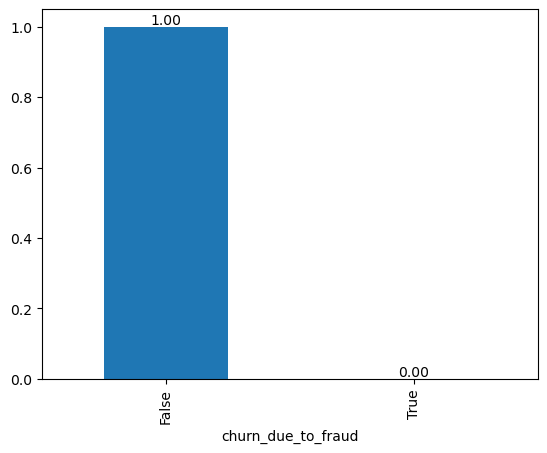

In [35]:
ax = train_data_new['churn_due_to_fraud'].value_counts(normalize = True).plot(kind = 'bar');
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10)
plt.show()

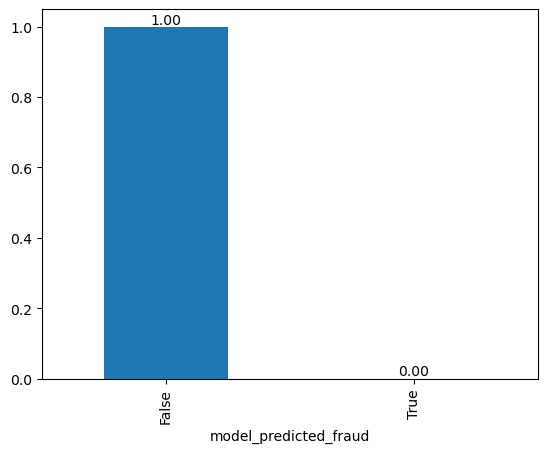

In [36]:
ax = train_data_new['model_predicted_fraud'].value_counts(normalize = True).plot(kind = 'bar');
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10)
plt.show()

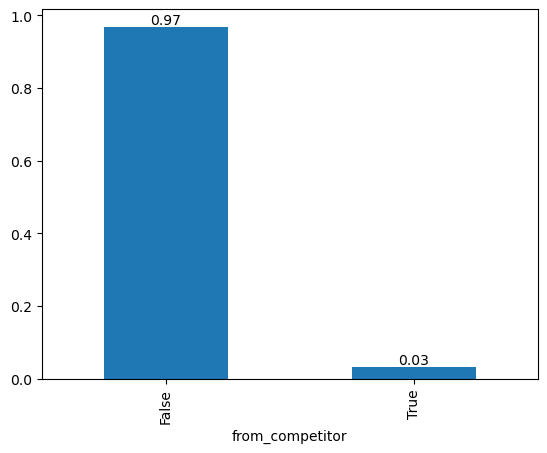

In [37]:
ax = train_data_new['from_competitor'].value_counts(normalize = True).plot(kind = 'bar');
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10)
plt.show()

In [38]:
train_data_new.describe().round(3)

,Id,customer_id,interest_rate,date,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,crypto_in_volume,crypto_out_volume,complaints,tenure,touchpoint,avg_csat_score
count,3926058.000,3926058.000,3926058.000,3926058,3926058.000,3926058.000,3926058.000,3926058.000,3926058.000,3926058.000,3926058.000,3926058.000,3926058.000,3926058.000,3926058.000,3926058.000,3926058.000,73000.000
mean,2163619.715,29765.242,0.522,2017-12-14 20:10:30.715082240,0.312,0.418,1187.016,806.643,8.698,3.457,1793.399,1114.901,115.286,49.104,0.021,723.034,0.199,6.503
min,1.000,1.000,0.000,2008-01-17 00:00:00,0.000,0.000,0.000,0.000,0.000,0.000,15.237,7.467,3.157,1.301,0.000,0.000,0.000,1.000
25%,1084868.500,8906.000,0.000,2014-12-28 00:00:00,0.000,0.000,2.000,2.000,1.000,1.000,91.211,25.868,43.470,13.000,0.000,23.000,0.000,5.500
50%,2167207.500,21624.000,0.000,2018-09-12 00:00:00,0.000,0.000,100.000,2.000,1.000,1.000,793.806,53.713,52.570,16.305,0.000,418.000,0.000,6.500
75%,3243857.750,45127.000,0.000,2021-04-29 00:00:00,0.000,0.000,536.000,7.000,6.000,6.000,1124.250,125.157,114.542,21.570,0.000,1127.000,0.000,7.500
max,4312994.000,106186.000,3.500,2023-12-31 00:00:00,2325.000,2497.000,34209.000,19464.000,83.000,78.000,39528.456,34826.612,2035.283,1214.428,3.000,5821.000,3.000,10.000
std,1245626.387,25925.160,1.043,NaN,19.448,23.540,2774.190,2083.132,16.845,4.419,3123.795,2746.087,163.204,91.489,0.220,834.600,0.651,1.494


##### Checking the job column as its the only object dtype

In [40]:
train_data_new['job'].value_counts()

job
unemployed                        349520
Analytical chemist                  7906
Scientist, research (maths)         7726
Musician                            7688
Armed forces technical officer      7595
                                   ...  
Designer, multimedia                4051
Interior and spatial designer       4016
Telecommunications researcher       4011
Quarry manager                      3968
Ceramics designer                   3814
Name: count, Length: 640, dtype: int64

##### To reduce redundancy, the unemployment column have more values than others. I will convert this column to a binary column

In [42]:
unemployed_keywords = ['unemployed', 'student', 'retired']
train_data_new['employment_status'] = train_data_new['job'].apply(
    lambda x: 'unemployed' if pd.isna(x) or any(word in x for word in unemployed_keywords) else 'employed'
)
train_data_new['employment_status'] = train_data_new['employment_status'].map({'employed': 1, 'unemployed': 0})
train_data_new.drop(columns = ['job'], inplace = True)

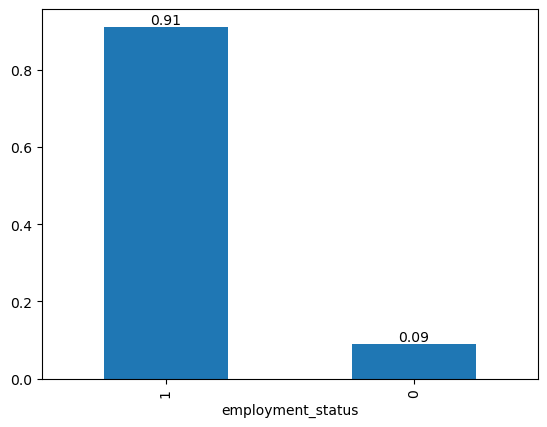

In [43]:
ax = train_data_new['employment_status'].value_counts(normalize = True).plot(kind = 'bar');
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10)
plt.show()

##### Getting the datetime column ready for my analysis. I will covert to year, month, weekday and also timestamp incase i'll need it

In [45]:
train_data_new['year'] = pd.to_datetime(train_data_new['date']).dt.year
train_data_new['month'] = pd.to_datetime(train_data_new['date']).dt.month
train_data_new['weekday'] = pd.to_datetime(train_data_new['date']).dt.weekday

In [46]:
train_data_new['date'] = pd.to_datetime(train_data_new['date'], utc=True)
# Convert to UNIX timestamp
train_data_new['utc_timestamp'] = train_data_new['date'].view('int64') // 10**9  # Convert to seconds

In [47]:
train_data_new['utc_timestamp'].sample(3)

2335224    1552694400
2537322    1570665600
1544298    1508284800
Name: utc_timestamp, dtype: int64

In [48]:
train_data_final = train_data_new.drop(columns = ['Id', 'name', 'date', 'country', 'address', 'date_of_birth', 'csat_scores', 'avg_csat_score'], axis = 1)

In [49]:
train_data_final.shape

(3926058, 23)

In [50]:
train_data_final.isna().sum()

customer_id                 0
interest_rate               0
atm_transfer_in             0
atm_transfer_out            0
bank_transfer_in            0
bank_transfer_out           0
crypto_in                   0
crypto_out                  0
bank_transfer_in_volume     0
bank_transfer_out_volume    0
crypto_in_volume            0
crypto_out_volume           0
complaints                  0
tenure                      0
from_competitor             0
churn_due_to_fraud          0
model_predicted_fraud       0
touchpoint                  0
employment_status           0
year                        0
month                       0
weekday                     0
utc_timestamp               0
dtype: int64

In [51]:
train_data_final.duplicated().sum()

0

In [52]:
train_data_final_copy = train_data_final.copy()

In [53]:
train_data_final.sample(2)

,customer_id,interest_rate,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,...,tenure,from_competitor,churn_due_to_fraud,model_predicted_fraud,touchpoint,employment_status,year,month,weekday,utc_timestamp
2950260,41229,0.0,0,0,4893,4922,50,12,7929.167079,6662.943371,...,755,False,False,False,2.0,1,2021,6,0,1624838400
1313418,13449,0.0,0,0,2,5,1,1,1014.360487,26.815828,...,823,False,False,False,0.0,0,2016,3,6,1457222400


##### To have a visual representation of the transactions over time

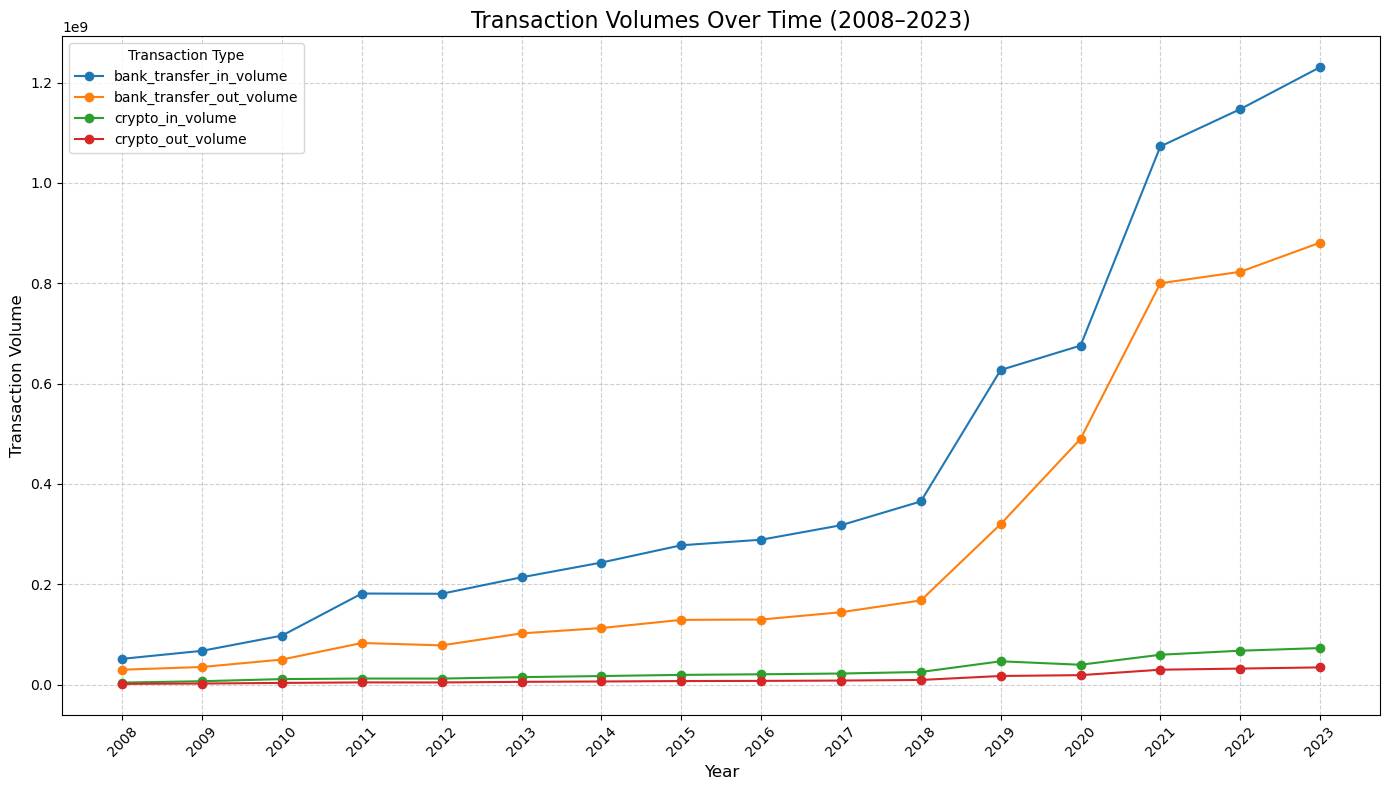

In [55]:
# Grouping by year and sum the transaction columns
transaction_columns = [
    'bank_transfer_in_volume', 'bank_transfer_out_volume',
    'crypto_in_volume', 'crypto_out_volume'
]
transactions_by_year = train_data_final.groupby('year')[transaction_columns].sum()
# Ploting each transaction type as a line on the same graph
plt.figure(figsize=(14, 8))
for column in transaction_columns:
    plt.plot(transactions_by_year.index, transactions_by_year[column], marker='o', label=column)
# Add title, labels, legend, and grid
plt.title("Transaction Volumes Over Time (2008–2023)", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Transaction Volume", fontsize=12)
plt.legend(title="Transaction Type", fontsize=10, loc="upper left")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(transactions_by_year.index, rotation=45)
plt.tight_layout()
plt.show()

##### Checking the overall sum of transaction in 2023

In [57]:
# Filter for the year 2023
transactions_2023 = train_data_final[train_data_final['year'] == 2023]
# Sum the transactions for all transaction columns in 2023
total_transactions_2023 = transactions_2023[transaction_columns].sum().sum()
print(f"Total number of transactions in 2023: {total_transactions_2023}")

Total number of transactions in 2023: 2219411823.179077


##### Checking the number of unique customer that had a transaction in 2023

In [59]:
unique_customers_2023 = transactions_2023['customer_id'].nunique()
print(f"Number of unique customers with transactions in 2023: {unique_customers_2023}")

Number of unique customers with transactions in 2023: 80640


##### Customers without transaction in 2023

In [61]:
total_number_of_customers = train_data['customer_id'].nunique()
customers_without_txn_2023 = total_number_of_customers - unique_customers_2023
print(f'Total number of customers that didnt have a transaction in 2023 is : {customers_without_txn_2023}')

Total number of customers that didnt have a transaction in 2023 is : 25539


##### This is a time series data with multiple customer id appearing over 160+ times. I need to get the overall transactions for each customer

In [63]:
features_list = train_data_final.columns.tolist()
print(features_list)

['customer_id', 'interest_rate', 'atm_transfer_in', 'atm_transfer_out', 'bank_transfer_in', 'bank_transfer_out', 'crypto_in', 'crypto_out', 'bank_transfer_in_volume', 'bank_transfer_out_volume', 'crypto_in_volume', 'crypto_out_volume', 'complaints', 'tenure', 'from_competitor', 'churn_due_to_fraud', 'model_predicted_fraud', 'touchpoint', 'employment_status', 'year', 'month', 'weekday', 'utc_timestamp']


In [64]:
customer_data = train_data_final.groupby('customer_id').agg({
    'interest_rate': 'mean',
    'atm_transfer_in': 'sum',
    'atm_transfer_out': 'sum',
    'bank_transfer_in': 'sum',
    'bank_transfer_out': 'sum',
    'crypto_in': 'sum',
    'crypto_out': 'sum',
    'bank_transfer_in_volume': 'sum',
    'bank_transfer_out_volume': 'sum',
    'crypto_in_volume': 'sum',
    'crypto_out_volume': 'sum',
    'complaints': 'sum',
    'tenure': 'max',
    'from_competitor': 'first',
    'churn_due_to_fraud': 'max',
    'model_predicted_fraud': 'max',
    'touchpoint': 'sum',
    'employment_status': 'max',
    'year': 'max',
    'month': 'max',
    'weekday': 'max',
    'utc_timestamp': 'max'
}).reset_index()

In [65]:
customer_data.shape

(106179, 23)

In [66]:
customer_data.sample(2)

,customer_id,interest_rate,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,...,tenure,from_competitor,churn_due_to_fraud,model_predicted_fraud,touchpoint,employment_status,year,month,weekday,utc_timestamp
62107,62109,0.454545,0,0,52505,48467,456,120,81298.553063,61913.587183,...,1171,False,False,False,2.0,1,2023,10,6,1696896000
32525,32527,0.041667,0,0,522551,133366,1310,420,221100.327117,168192.560158,...,1566,False,False,False,6.0,1,2023,12,6,1675555200


## Defining Churn and feature Engineering 

##### Churn will be defined as customers without transaction in last 365 days from the max date. I will use time based features as this will help capture useful information earlier to assist a customer who is likely going to churn 

##### txn_gap_ratio measures the proportion of inactivity compared to tenure for each customer. If a customer has been inactive for a long time but has short tenure, they are more likely to churn.

##### txn_gap_tenure combines inactivity and tenure to capture patterns. A low value means either short tenure or recent transactions, meaning lower churn risk.

##### transaction_frequency calculates the average number of transactions per day since the customer joined. Higher values = active customers, lower churn risk. Lower values = low activity, potential churn risk

##### volume_per_transaction. It calculates the average amount of each customers transaction. Higher values = customers make fewer transactions, but larger amounts (could indicate long-term investors). Lower values = customers make frequent small transactions (likely engaged users).

##### recent_activity, If days_since_last_txn ≤ 90, the customer has been active in the last 90 days. If days_since_last_txn > 90, they have been inactive for over 3 months. This feature could help follow up on the customer and try to improve the customer experince to reduce feature churn likelihood

In [74]:
# Assuming 'customer_data' is your aggregated dataset
def feature_engineering(customer_data):
    # Convert timestamp to datetime if not already
    customer_data['utc_datetime'] = pd.to_datetime(customer_data['utc_timestamp'], unit='s', utc=True)    
    # Define churn cutoff date (modify if needed)
    last_date = customer_data['utc_datetime'].max()    
    # Days since last transaction
    customer_data['days_since_last_txn'] = (last_date - customer_data['utc_datetime']).dt.days    
    # Interaction Features
    customer_data['txn_gap_ratio'] = customer_data['days_since_last_txn'] / (customer_data['tenure'] + 1)  # Avoid division by zero
    customer_data['txn_gap_tenure'] = customer_data['days_since_last_txn'] * customer_data['tenure']    
    # Velocity Features
    customer_data['transaction_frequency'] = (customer_data['bank_transfer_in'] + customer_data['bank_transfer_out'] +
                                              customer_data['crypto_in'] + customer_data['crypto_out']) / (customer_data['tenure'] + 1)
    
    customer_data['volume_per_transaction'] = (customer_data['bank_transfer_in_volume'] + customer_data['bank_transfer_out_volume'] +
                                               customer_data['crypto_in_volume'] + customer_data['crypto_out_volume']) / \
                                              (customer_data['bank_transfer_in'] + customer_data['bank_transfer_out'] +
                                               customer_data['crypto_in'] + customer_data['crypto_out'] + 1)   
    # Recent Activity Features (modify transaction history period as needed)
    customer_data['recent_activity'] = (customer_data['days_since_last_txn'] <= 90).astype(int)  # Active in last 90 days    
    return customer_data
# Apply feature engineering
customer_data = feature_engineering(customer_data)
# Preview the updated dataset
customer_data.sample(3)

,customer_id,interest_rate,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,...,month,weekday,utc_timestamp,utc_datetime,days_since_last_txn,txn_gap_ratio,txn_gap_tenure,transaction_frequency,volume_per_transaction,recent_activity
79061,79064,2.083333,0,0,2467,13,6,6,4870.685212,595.211502,...,12,6,1675123200,2023-01-31 00:00:00+00:00,334,0.832918,133600,6.214464,2.337251,0
67289,67291,0.000000,0,0,30959,26030,252,81,54973.143473,36190.899112,...,12,6,1672185600,2022-12-28 00:00:00+00:00,368,0.469987,287776,73.208174,1.649363,0
18037,18039,0.000000,0,0,6299,84,177,209,13080.299605,2440.389697,...,8,6,1534291200,2018-08-15 00:00:00+00:00,1964,1.638032,2352872,5.645538,3.025272,0


In [75]:
threshold_days = 365
customer_data['churn'] = customer_data['days_since_last_txn'] > threshold_days
customer_data.sample(2)

,customer_id,interest_rate,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,...,weekday,utc_timestamp,utc_datetime,days_since_last_txn,txn_gap_ratio,txn_gap_tenure,transaction_frequency,volume_per_transaction,recent_activity,churn
92551,92555,2.500000,0,0,2107,148,2,2,1563.344095,192.531904,...,4,1675382400,2023-02-03 00:00:00+00:00,331,165.50000,331,1129.500000,0.836348,0,False
47065,47067,0.138889,0,0,30181,1393,54,54,43362.472334,3970.145612,...,6,1701648000,2023-12-04 00:00:00+00:00,27,0.01767,41229,20.734293,1.577716,1,False


#### Visaulization of the data distribution 

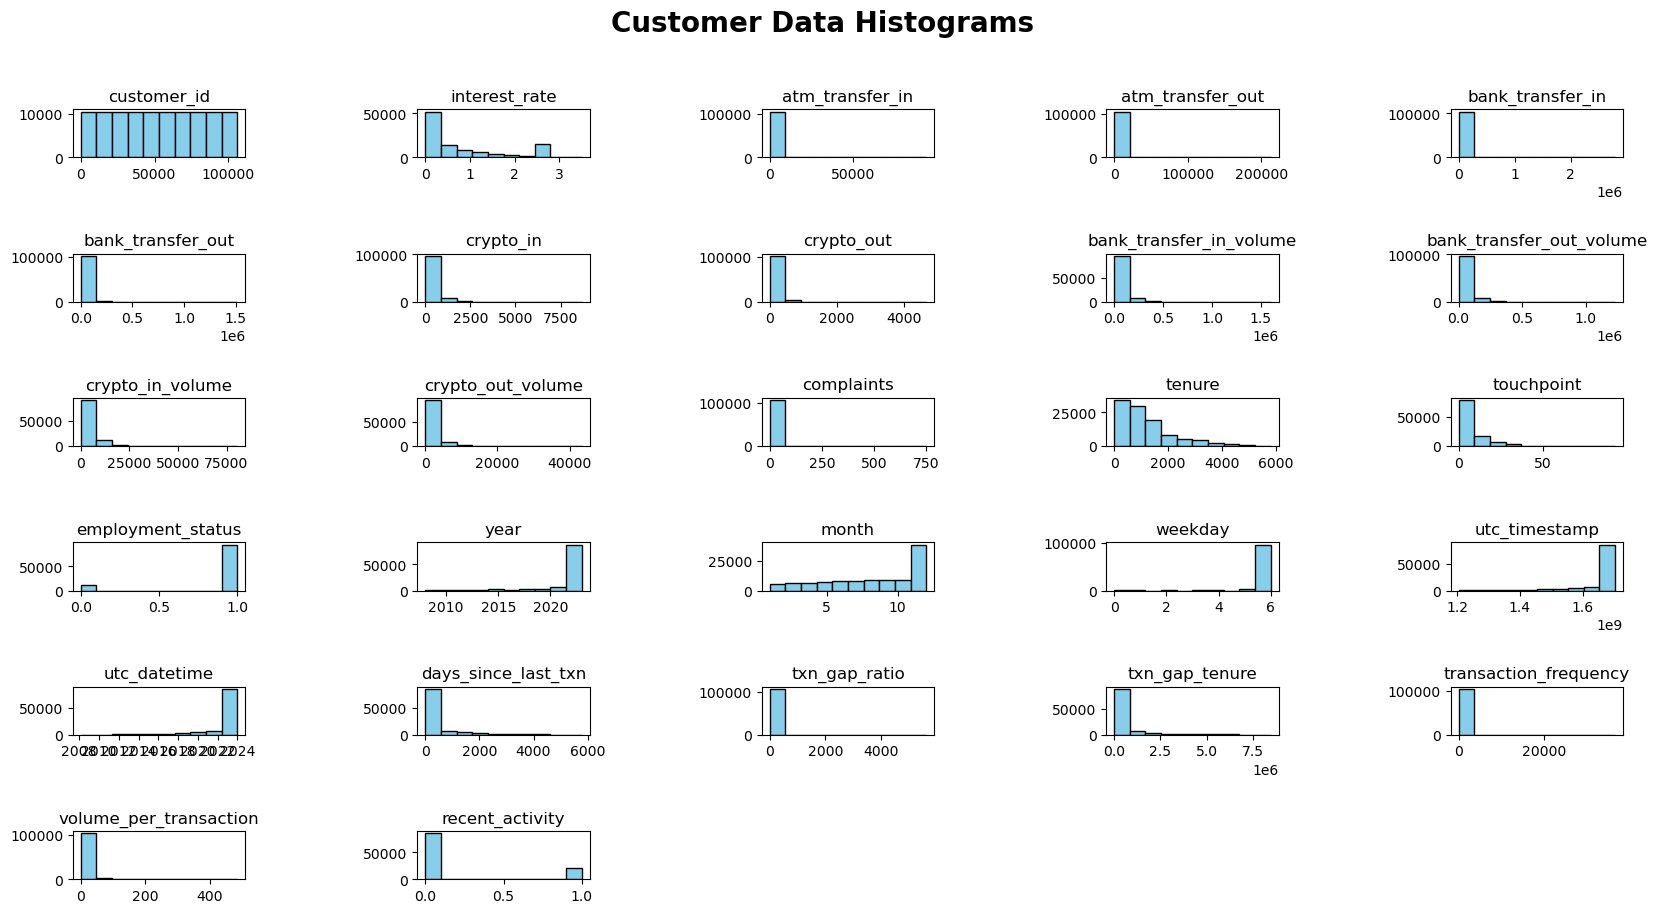

In [77]:
customer_data.hist(figsize=(20, 10), grid=False, color='skyblue', edgecolor='black')
plt.subplots_adjust(hspace=2.0, wspace=1.0)  # More space between subplots
plt.suptitle("Customer Data Histograms", fontsize=20, fontweight='bold')
plt.show()

### Correlation 

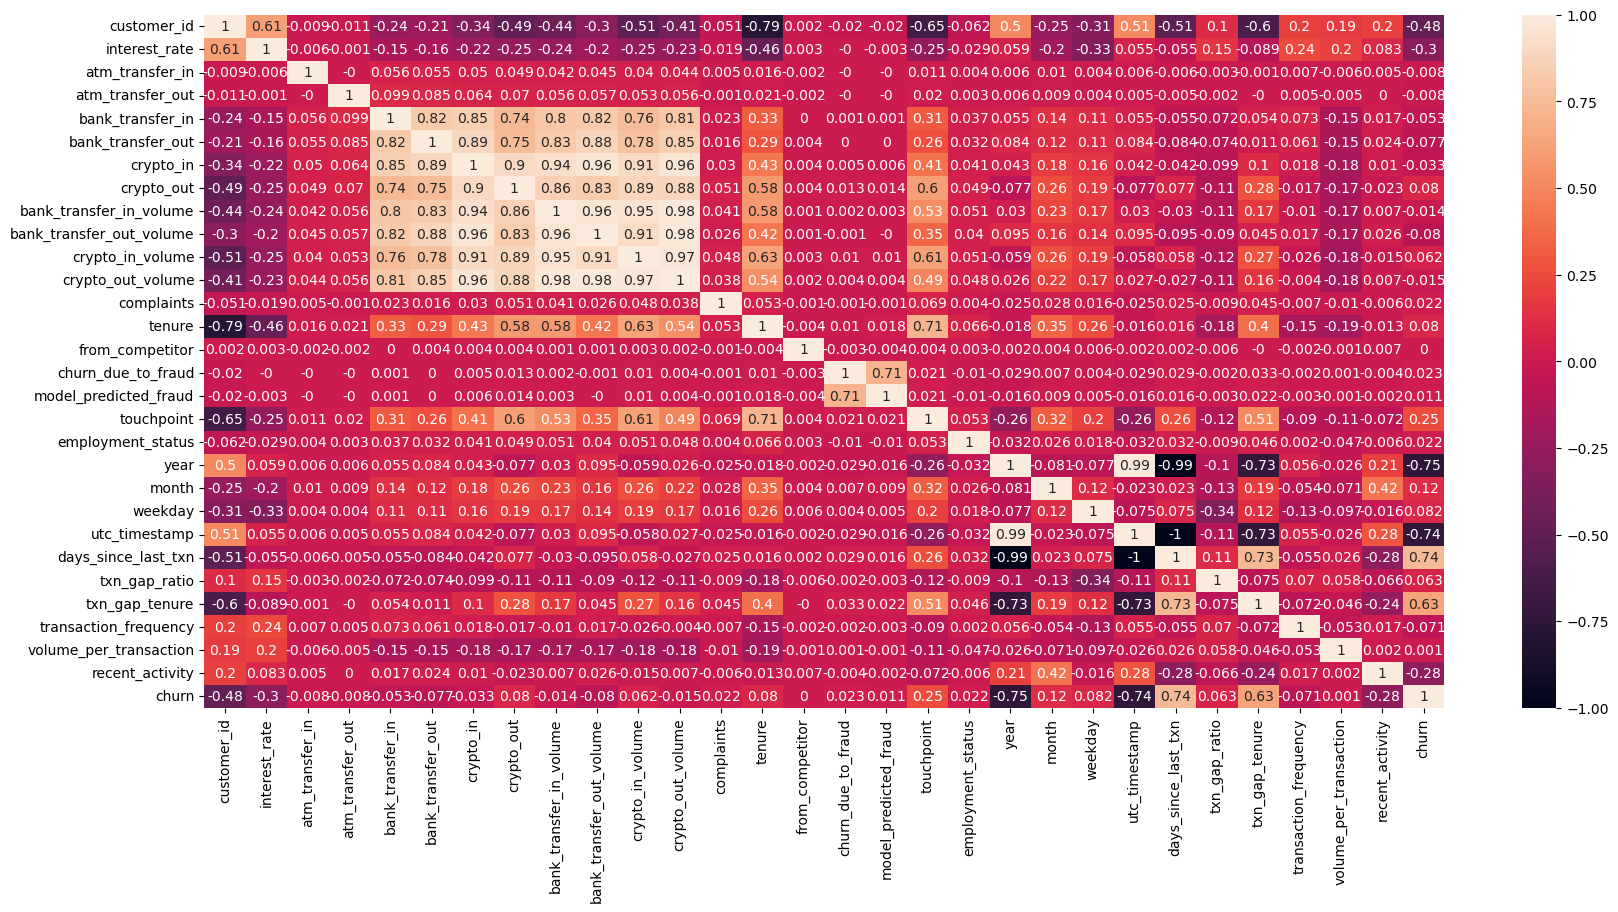

In [79]:
corr = customer_data.corr(numeric_only = True).round(3)
plt.figure(figsize = (20,9))
sns.heatmap(corr, annot = True);

### Triangular correlation 

##### From the heatmap, we can see multicollinearity 

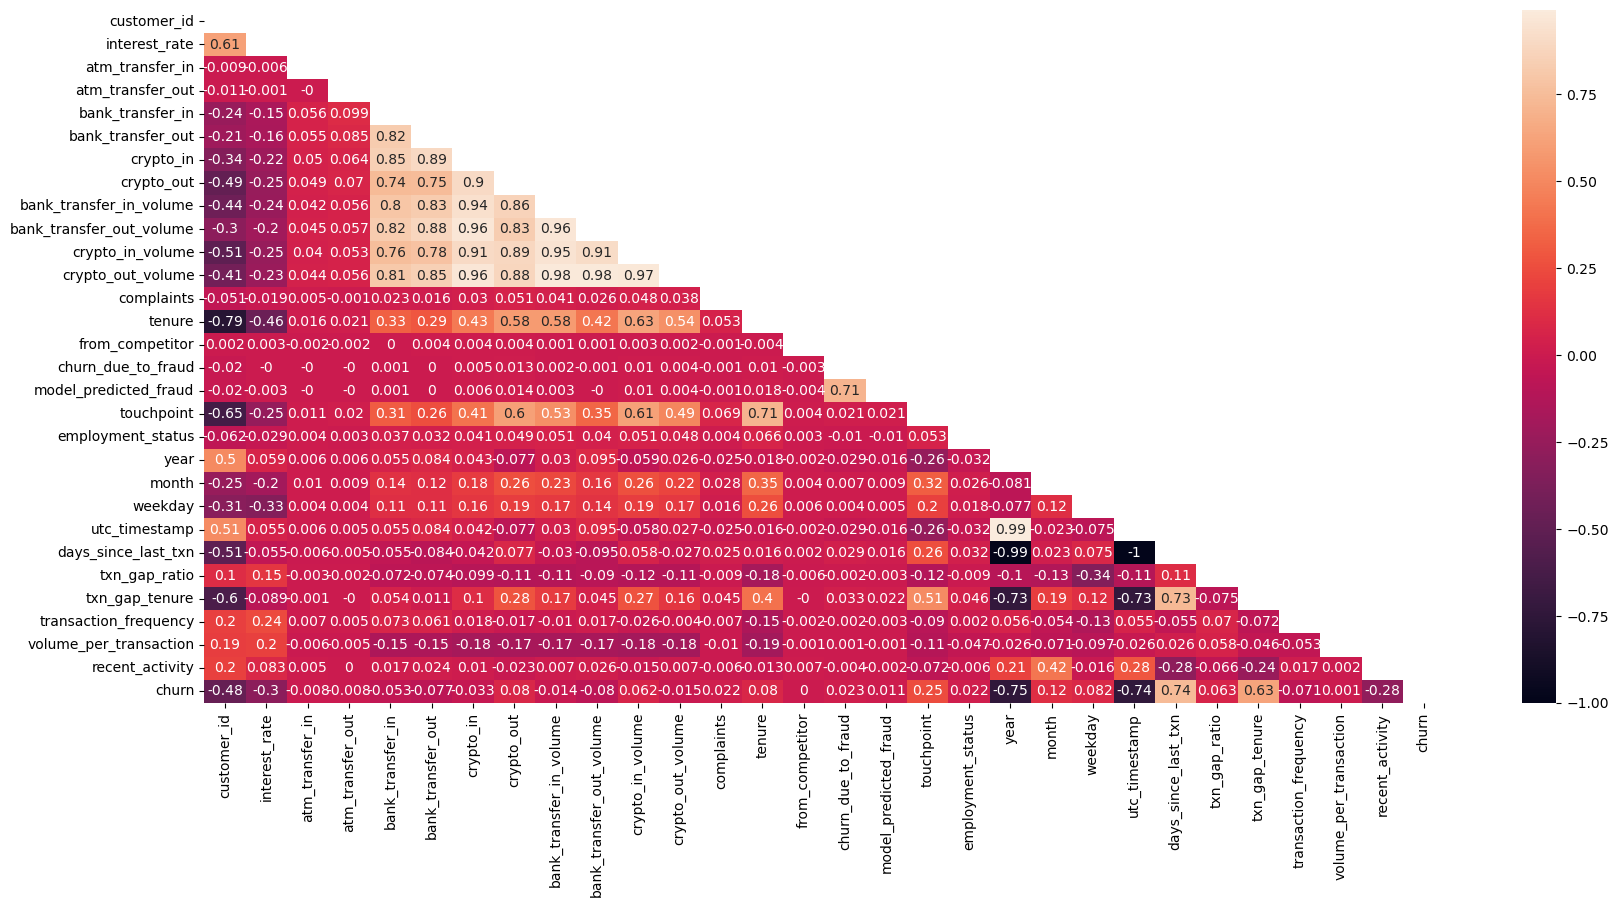

In [82]:
mask = np.triu(np.ones_like(customer_data.corr(numeric_only = True).round(2)))
plt.figure(figsize = (20, 9))
sns.heatmap(corr, annot = True, mask = mask);

In [83]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106179 entries, 0 to 106178
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype              
---  ------                    --------------   -----              
 0   customer_id               106179 non-null  int64              
 1   interest_rate             106179 non-null  float64            
 2   atm_transfer_in           106179 non-null  int64              
 3   atm_transfer_out          106179 non-null  int64              
 4   bank_transfer_in          106179 non-null  int64              
 5   bank_transfer_out         106179 non-null  int64              
 6   crypto_in                 106179 non-null  int64              
 7   crypto_out                106179 non-null  int64              
 8   bank_transfer_in_volume   106179 non-null  float64            
 9   bank_transfer_out_volume  106179 non-null  float64            
 10  crypto_in_volume          106179 non-null  float64            
 11  

##### Churn distribution 

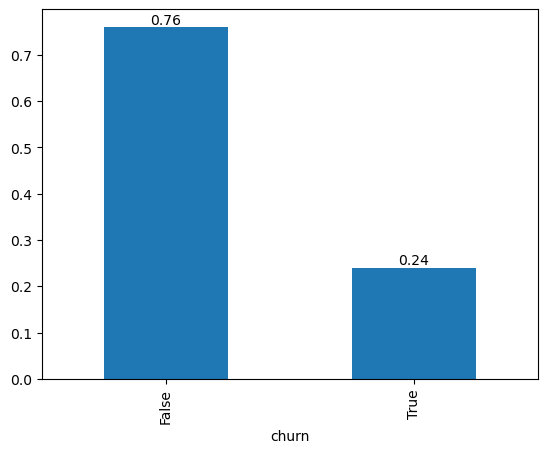

In [85]:
ax = customer_data['churn'].value_counts(normalize = True).round(2).plot(kind = "bar");
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10)
plt.show()

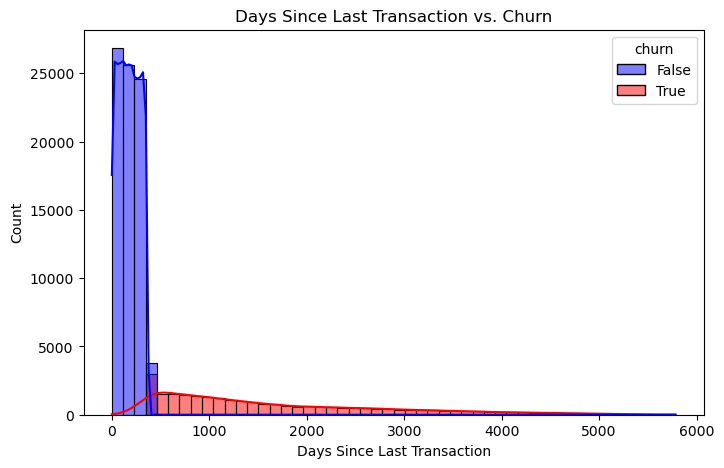

In [86]:
plt.figure(figsize=(8, 5))
sns.histplot(data=customer_data, x="days_since_last_txn", hue="churn", kde=True, bins=50, palette=['blue', 'red'])
plt.title("Days Since Last Transaction vs. Churn")
plt.xlabel("Days Since Last Transaction")
plt.ylabel("Count")

# Saving the plot
plt.savefig("days_since_last_txn.png", dpi=300, bbox_inches="tight")  # Saves as a high-resolution image
plt.show()

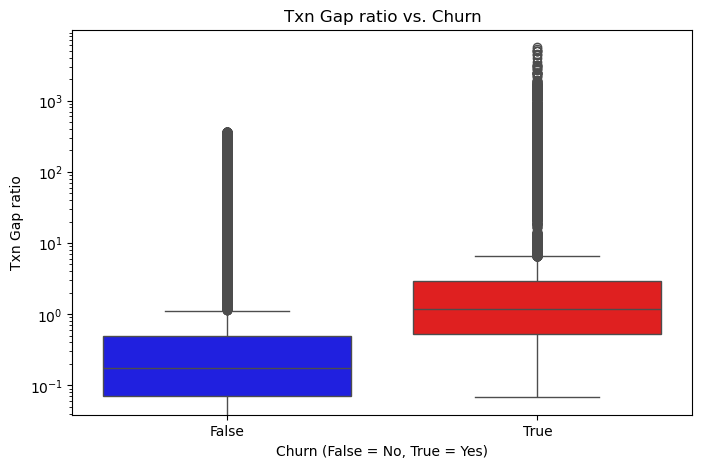

In [87]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=customer_data, x="churn", y="txn_gap_ratio", palette=['blue', 'red'])
plt.title("Txn Gap ratio vs. Churn")
plt.xlabel("Churn (False = No, True = Yes)")
plt.ylabel("Txn Gap ratio")
plt.yscale("log")  

# Saving the plot
plt.savefig("txn_gap_ratio.png", dpi=300, bbox_inches="tight")  # Saves as a high-resolution image
plt.show()

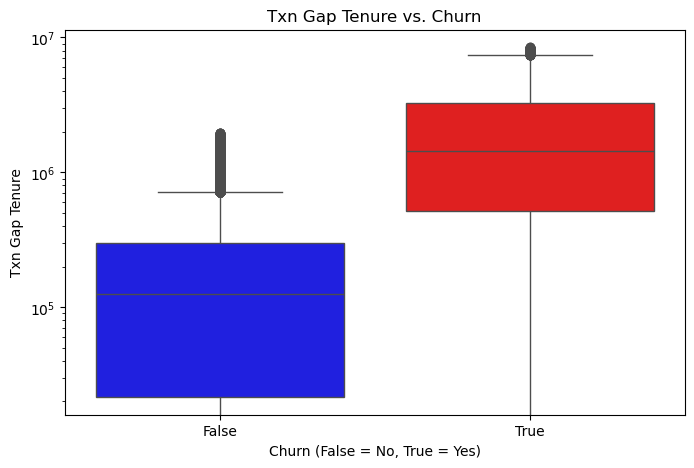

In [88]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=customer_data, x="churn", y="txn_gap_tenure", palette=['blue', 'red'])
plt.title("Txn Gap Tenure vs. Churn")
plt.xlabel("Churn (False = No, True = Yes)")
plt.ylabel("Txn Gap Tenure")
plt.yscale("log")  

# Saving the plot
plt.savefig("txn_gap_tenure.png", dpi=300, bbox_inches="tight")  # Saves as a high-resolution image
plt.show()

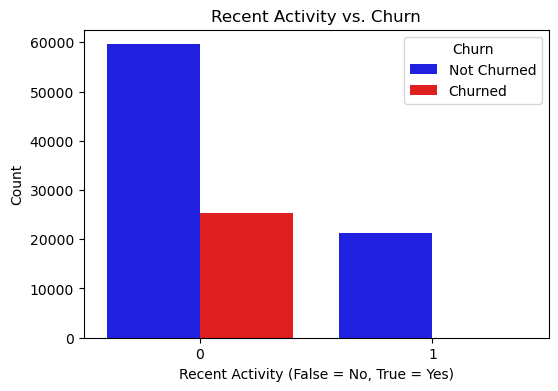

In [89]:
plt.figure(figsize=(6, 4))
sns.countplot(data=customer_data, x="recent_activity", hue="churn", palette=['blue', 'red'])
plt.title("Recent Activity vs. Churn")
plt.xlabel("Recent Activity (False = No, True = Yes)")
plt.ylabel("Count")
plt.legend(title="Churn", labels=["Not Churned", "Churned"])

# Saving the plot
plt.savefig("recent_activity.png", dpi=300, bbox_inches="tight")  # Saves as a high-resolution image
plt.show()

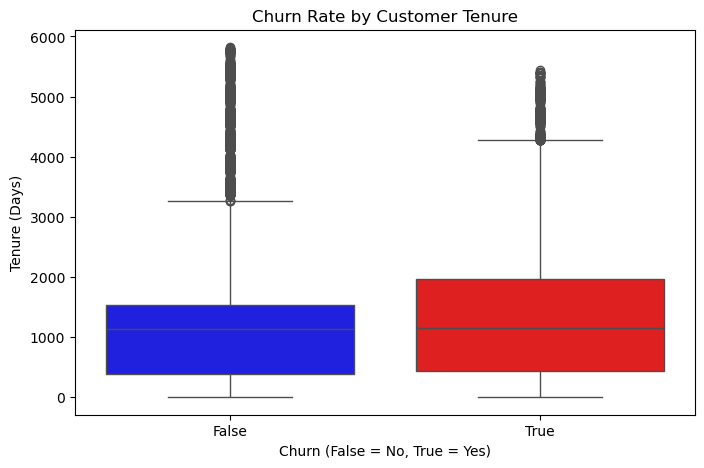

In [90]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=customer_data, x="churn", y="tenure", palette=['blue', 'red'])
plt.title("Churn Rate by Customer Tenure")
plt.xlabel("Churn (False = No, True = Yes)")
plt.ylabel("Tenure (Days)")
# Saving the plot
plt.savefig("tenure.png", dpi=300, bbox_inches="tight")  # Saves as a high-resolution image
plt.show()

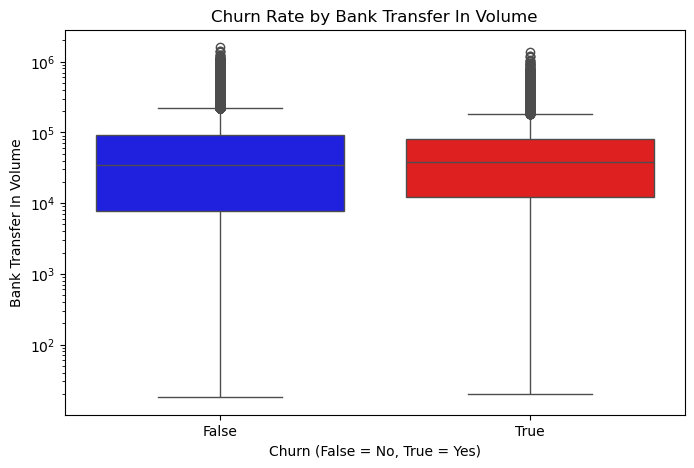

In [91]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=customer_data, x="churn", y="bank_transfer_in_volume", palette=['blue', 'red'])
plt.title("Churn Rate by Bank Transfer In Volume")
plt.xlabel("Churn (False = No, True = Yes)")
plt.ylabel("Bank Transfer In Volume")
plt.yscale("log")  
plt.show()

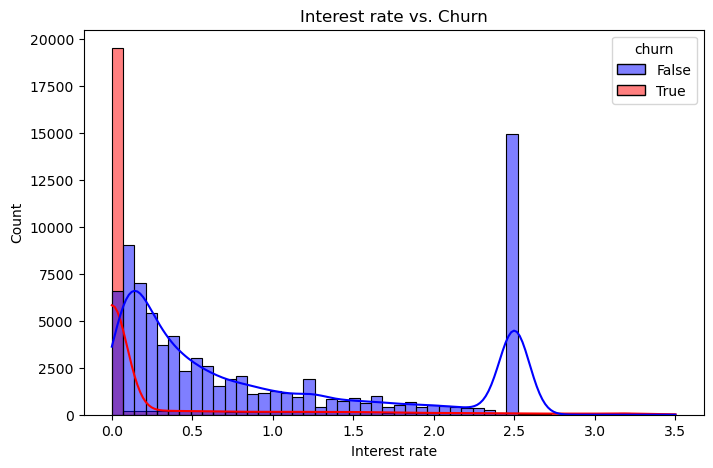

In [92]:
plt.figure(figsize=(8, 5))
sns.histplot(data=customer_data, x="interest_rate", hue="churn", kde=True, bins=50, palette=['blue', 'red'])
plt.title("Interest rate vs. Churn")
plt.xlabel("Interest rate")
plt.ylabel("Count")

# Saving the plot
plt.savefig("interest_rate.png", dpi=300, bbox_inches="tight")  # Saves as a high-resolution image
plt.show()

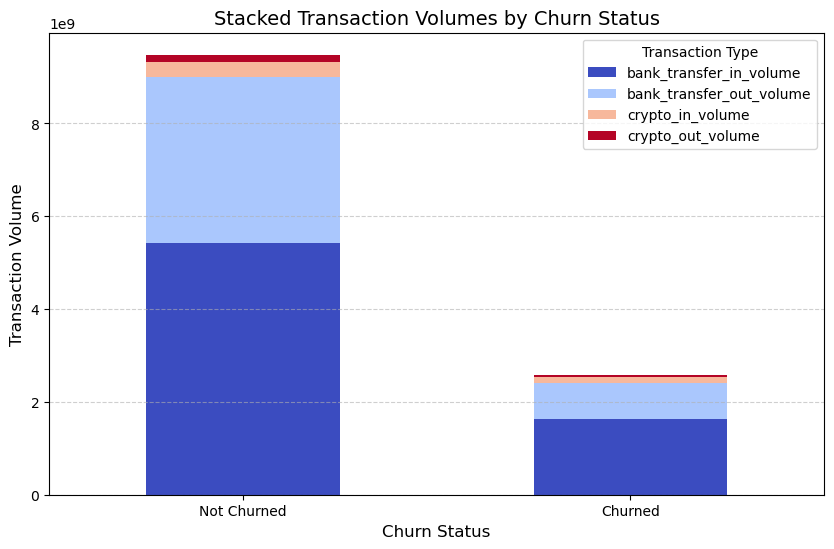

In [93]:
transaction_columns = [
    'bank_transfer_in_volume', 'bank_transfer_out_volume',
    'crypto_in_volume', 'crypto_out_volume'
]
transactions_by_churn = customer_data.groupby('churn')[transaction_columns].sum()
transactions_by_churn.plot(
    kind='bar', stacked=True, figsize=(10, 6), colormap="coolwarm"
)
plt.title("Stacked Transaction Volumes by Churn Status", fontsize=14)
plt.xlabel("Churn Status", fontsize=12)
plt.ylabel("Transaction Volume", fontsize=12)
plt.xticks(ticks=[0, 1], labels=["Not Churned", "Churned"], rotation=0)
plt.legend(title="Transaction Type", fontsize=10)
plt.grid(axis='y', linestyle="--", alpha=0.6)

# Saving the plot
plt.savefig("transaction_columns.png", dpi=300, bbox_inches="tight")  # Saves as a high-resolution image
plt.show()

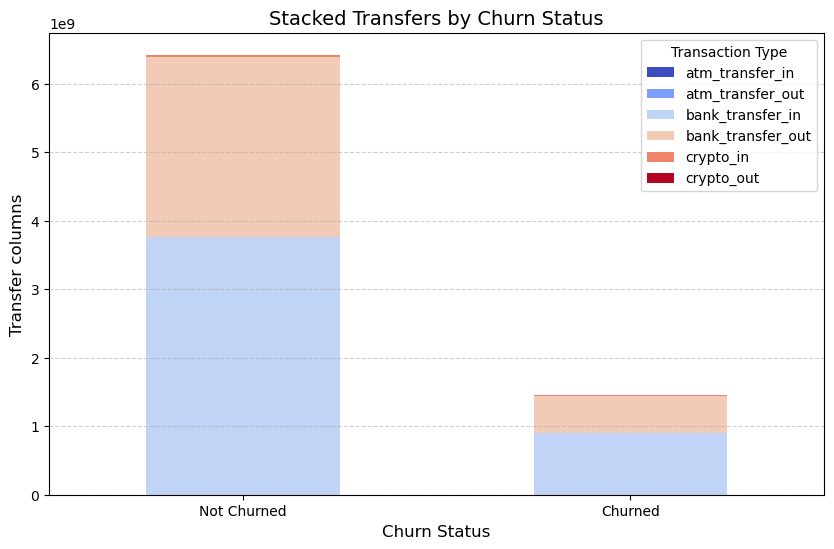

In [94]:
transfer_columns = [
    'atm_transfer_in', 'atm_transfer_out', 'bank_transfer_in', 'bank_transfer_out',
    'crypto_in', 'crypto_out'
]
transfers_by_churn = customer_data.groupby('churn')[transfer_columns].sum()
transfers_by_churn.plot(
    kind='bar', stacked=True, figsize=(10, 6), colormap="coolwarm"
)
plt.title("Stacked Transfers by Churn Status", fontsize=14)
plt.xlabel("Churn Status", fontsize=12)
plt.ylabel("Transfer columns", fontsize=12)
plt.xticks(ticks=[0, 1], labels=["Not Churned", "Churned"], rotation=0)
plt.legend(title="Transaction Type", fontsize=10)
plt.grid(axis='y', linestyle="--", alpha=0.6)

# Saving the plot
plt.savefig("transfer_columns.png", dpi=300, bbox_inches="tight")  # Saves as a high-resolution image
plt.show()

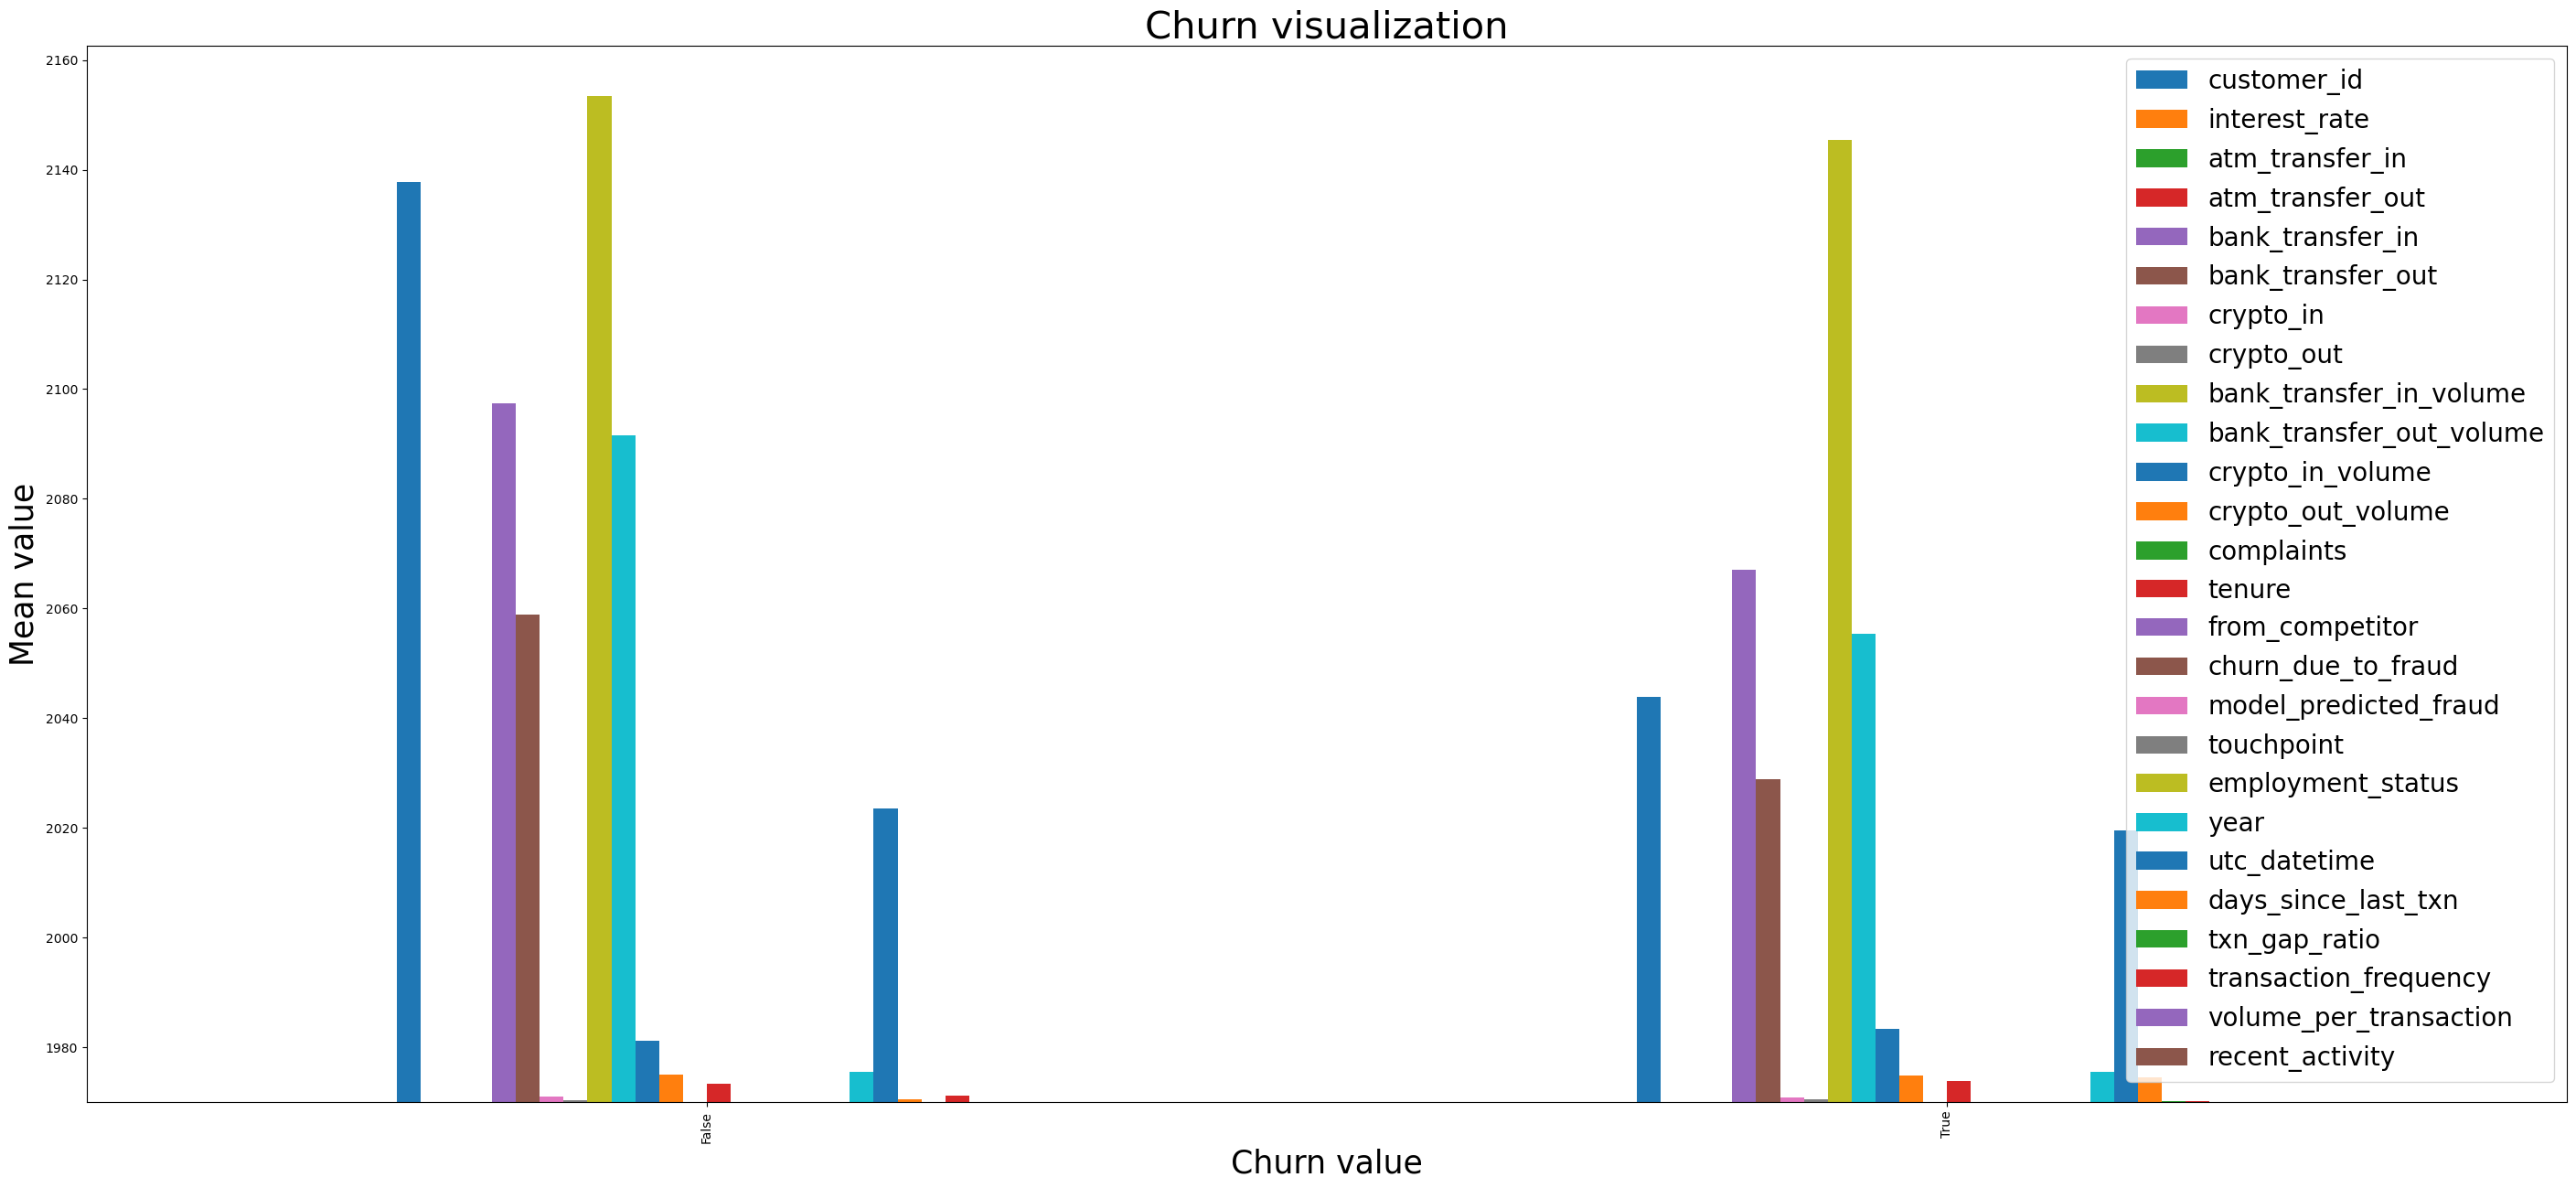

In [95]:
churn_view = customer_data.drop(columns = ['month', 'weekday', 'txn_gap_tenure', 'utc_timestamp'], axis = 1)
churn_view.groupby('churn').mean().plot(kind = 'bar', figsize = (35, 15))
plt.xlabel('Churn value', fontsize = 25)
plt.ylabel('Mean value', fontsize = 25)
plt.title('Churn visualization', fontsize = 30)
plt.legend( fontsize = 20, loc = 'upper right');

# Saving the plot
plt.savefig("overall_view.png", dpi=300, bbox_inches="tight")  # Saves as a high-resolution image
plt.show()

## Building The Model 

##### Data Inspection 

In [98]:
customer_data.sample(2)

,customer_id,interest_rate,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,...,weekday,utc_timestamp,utc_datetime,days_since_last_txn,txn_gap_ratio,txn_gap_tenure,transaction_frequency,volume_per_transaction,recent_activity,churn
16526,16528,0.239726,0,0,10697,123,197,181,54402.019192,4022.042016,...,6,1684368000,2023-05-18 00:00:00+00:00,227,0.073202,703700,3.611093,5.534590,0,False
49732,49734,0.000000,0,0,10828,5026,87,44,29139.718156,8587.167427,...,6,1642550400,2022-01-19 00:00:00+00:00,711,0.898862,561690,20.208597,2.501076,0,True


##### I will drop some columns that directly defined churn to avoid data leakage 

In [100]:
customer_data_df = customer_data.drop(columns = ['utc_timestamp', 'utc_datetime', 'days_since_last_txn',  'year', 'month', 'weekday'], axis =1) 

In [101]:
customer_data_df.shape

(106179, 25)

In [102]:
customer_data_df.isna().sum()

customer_id                 0
interest_rate               0
atm_transfer_in             0
atm_transfer_out            0
bank_transfer_in            0
bank_transfer_out           0
crypto_in                   0
crypto_out                  0
bank_transfer_in_volume     0
bank_transfer_out_volume    0
crypto_in_volume            0
crypto_out_volume           0
complaints                  0
tenure                      0
from_competitor             0
churn_due_to_fraud          0
model_predicted_fraud       0
touchpoint                  0
employment_status           0
txn_gap_ratio               0
txn_gap_tenure              0
transaction_frequency       0
volume_per_transaction      0
recent_activity             0
churn                       0
dtype: int64

In [103]:
customer_data_df.duplicated().sum()

0

In [104]:
customer_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106179 entries, 0 to 106178
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   customer_id               106179 non-null  int64  
 1   interest_rate             106179 non-null  float64
 2   atm_transfer_in           106179 non-null  int64  
 3   atm_transfer_out          106179 non-null  int64  
 4   bank_transfer_in          106179 non-null  int64  
 5   bank_transfer_out         106179 non-null  int64  
 6   crypto_in                 106179 non-null  int64  
 7   crypto_out                106179 non-null  int64  
 8   bank_transfer_in_volume   106179 non-null  float64
 9   bank_transfer_out_volume  106179 non-null  float64
 10  crypto_in_volume          106179 non-null  float64
 11  crypto_out_volume         106179 non-null  float64
 12  complaints                106179 non-null  int64  
 13  tenure                    106179 non-null  i

#### Data Prep For Modelling 

##### Scaling The Data

##### Droping the boolean, binary and target column. Scaling other numeric column

In [108]:
numeric_col = customer_data_df.drop(columns = ['customer_id','from_competitor', 'churn_due_to_fraud', 'model_predicted_fraud', 'employment_status',
                                                'churn'], axis = 1)

In [109]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
numeric_col_scaled = scaler.fit_transform(numeric_col)
numeric_col_scaled = pd.DataFrame(numeric_col_scaled, columns = numeric_col.columns)

##### Concat The boolean, binary features back to the scaled features

In [111]:
customer_data_pred = pd.concat([numeric_col_scaled, customer_data_df[['from_competitor', 'churn_due_to_fraud', 'model_predicted_fraud',
                                'employment_status','churn']].reset_index(drop = True)], axis = 1)
customer_data_pred.sample(2)

,interest_rate,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,crypto_in_volume,...,txn_gap_ratio,txn_gap_tenure,transaction_frequency,volume_per_transaction,recent_activity,from_competitor,churn_due_to_fraud,model_predicted_fraud,employment_status,churn
99052,1.892826,-0.020058,-0.016596,-0.478915,-0.491733,-0.661517,-0.781147,-0.709148,-0.58521,-0.791427,...,0.862953,-0.514915,0.073175,-0.298374,-0.500444,False,False,False,1,False
43477,-0.874953,-0.020058,-0.016596,-0.410114,-0.493359,-0.514574,-0.439730,-0.531071,-0.56401,-0.620671,...,-0.149887,-0.005463,-0.156235,-0.233199,-0.500444,False,False,False,1,True


##### Import Train Test Slip

In [113]:
from sklearn.model_selection import train_test_split

##### I will Use The Train_set Validation_Set Approach

In [115]:
X_train_data = customer_data_pred.drop('churn', axis = 1)
y_train_data = customer_data_pred['churn']

In [116]:
print(X_train_data.columns.tolist())

['interest_rate', 'atm_transfer_in', 'atm_transfer_out', 'bank_transfer_in', 'bank_transfer_out', 'crypto_in', 'crypto_out', 'bank_transfer_in_volume', 'bank_transfer_out_volume', 'crypto_in_volume', 'crypto_out_volume', 'complaints', 'tenure', 'touchpoint', 'txn_gap_ratio', 'txn_gap_tenure', 'transaction_frequency', 'volume_per_transaction', 'recent_activity', 'from_competitor', 'churn_due_to_fraud', 'model_predicted_fraud', 'employment_status']


In [117]:
X_train, X_val, y_train, y_val = train_test_split(X_train_data, y_train_data, test_size = 0.2, random_state = 22, stratify = y_train_data) 

##### Checking the y distribution

In [119]:
y_val.value_counts(normalize = True).round(3)

churn
False    0.761
True     0.239
Name: proportion, dtype: float64

In [120]:
y_train.value_counts(normalize = True).round(3)

churn
False    0.761
True     0.239
Name: proportion, dtype: float64

###### there is more weight on the False, but we'll build the model and see if the recall and F1 is poor on the True. If the model is fine then no problem but if it gives less accuracy to True then we'll try oversampling the minority

##### Using DummyClassifier to train the model

In [123]:
from sklearn.dummy import DummyClassifier

##### Baseline model 

In [125]:
# Initialize DummyClassifier with desired strategy
dummy = DummyClassifier(strategy="most_frequent", random_state=22)
dummy.fit(X_train, y_train)
dm_train_score = dummy.score(X_train, y_train)
dm_val_score = dummy.score(X_val, y_val)
# Evaluate DummyClassifier performance
print(f'Dummy Classifier score, the train score is :{dm_train_score:.3f}, the val score is :{dm_val_score:.3f}')

Dummy Classifier score, the train score is :0.761, the val score is :0.761


##### Building with Randomforest Classifier

In [127]:
from sklearn.ensemble import RandomForestClassifier

In [128]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 22)
rf_model.fit(X_train, y_train)
rf_train_score = rf_model.score(X_train, y_train)
rf_val_score = rf_model.score(X_val, y_val)
print(f'The train score is :{rf_train_score:.3f}, and the val score is :{rf_val_score:.3f}')

The train score is :1.000, and the val score is :0.998


##### Getting feature importance 

                    features  importance
0              interest_rate    0.439470
15            txn_gap_tenure    0.268920
14             txn_gap_ratio    0.139622
12                    tenure    0.037013
13                touchpoint    0.023708
18           recent_activity    0.013105
6                 crypto_out    0.012813
10         crypto_out_volume    0.012108
9           crypto_in_volume    0.010233
8   bank_transfer_out_volume    0.009038
16     transaction_frequency    0.008484
4          bank_transfer_out    0.007401
17    volume_per_transaction    0.005910
7    bank_transfer_in_volume    0.005660
3           bank_transfer_in    0.003240
5                  crypto_in    0.002766
22         employment_status    0.000175
2           atm_transfer_out    0.000102
1            atm_transfer_in    0.000091
11                complaints    0.000073
19           from_competitor    0.000058
21     model_predicted_fraud    0.000009
20        churn_due_to_fraud    0.000001


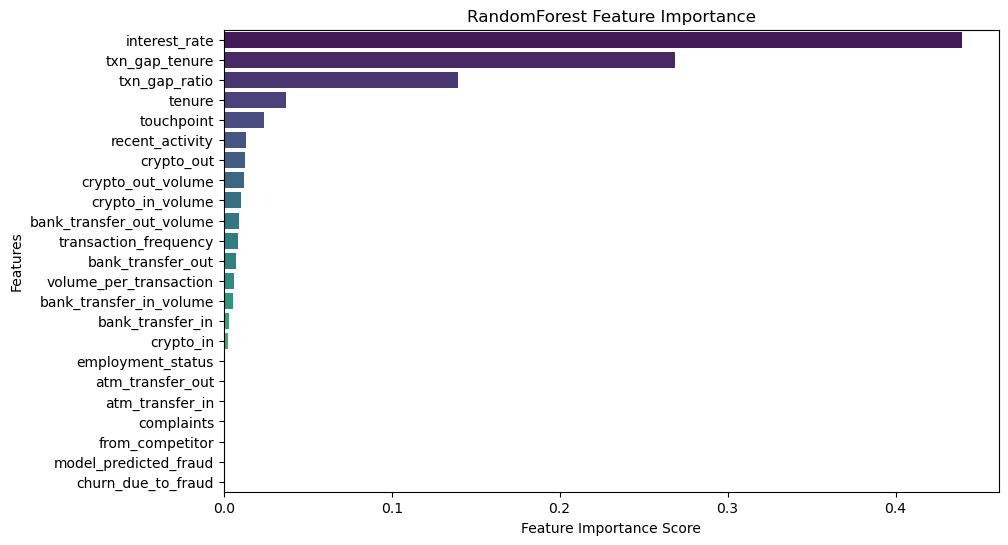

In [130]:
importance = rf_model.feature_importances_
feature_name = X_train.columns
importances_df = (
    pd.DataFrame({
        "features": feature_name, "importance": importance})
    .sort_values(by = "importance", ascending = False)
)
print(importances_df)
plt.figure(figsize=(10,6))
sns.barplot(x = "importance", y = "features", data = importances_df, palette = "viridis")
plt.title("RandomForest Feature Importance")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.show()

##### Dropping the columns with no contribution 

In [132]:
Rf_X_train_data = X_train_data.drop(columns = ['employment_status', 'atm_transfer_out', 'atm_transfer_in', 'complaints', 'from_competitor',
                                     'churn_due_to_fraud', 'model_predicted_fraud'], axis = 1)

In [133]:
rf_X_train, rf_X_val, y_train, y_val = train_test_split(Rf_X_train_data, y_train_data, test_size = 0.2, random_state = 22, stratify = y_train_data)

In [134]:
rf_model_reduced = RandomForestClassifier(n_estimators = 100, random_state = 22)
rf_model_reduced.fit(rf_X_train, y_train)
rf_train_score_reduced = rf_model_reduced.score(rf_X_train, y_train)
rf_val_score_reduced = rf_model_reduced.score(rf_X_val, y_val)
print(f'The train score is :{rf_train_score_reduced:.3f}, and the val score is :{rf_val_score_reduced:.3f}')

The train score is :1.000, and the val score is :0.998


##### Building with Xgboost

In [136]:
import xgboost as xgb
from xgboost import XGBClassifier

In [137]:
xgb_model = XGBClassifier(
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Step size shrinkage
    max_depth=3,        # Maximum depth of a tree
    subsample=0.8,      # Fraction of samples used for training each tree
    colsample_bytree=0.8,  # Fraction of features used per tree
    random_state=22
)

xgb_model.fit(X_train, y_train)
xgb_train_score = xgb_model.score(X_train, y_train)
xgb_val_score = xgb_model.score(X_val, y_val)
print(f' The train score is :{xgb_train_score:.3f}, the val score is :{xgb_val_score:.3f}')

 The train score is :0.998, the val score is :0.998


##### Xgboost Feature importance 

                     Feature  Importance
0              interest_rate    0.596334
15            txn_gap_tenure    0.200443
14             txn_gap_ratio    0.060781
13                touchpoint    0.052832
12                    tenure    0.037473
18           recent_activity    0.036861
7    bank_transfer_in_volume    0.003026
3           bank_transfer_in    0.002044
6                 crypto_out    0.002013
16     transaction_frequency    0.001543
17    volume_per_transaction    0.001487
9           crypto_in_volume    0.001411
4          bank_transfer_out    0.001232
10         crypto_out_volume    0.000909
8   bank_transfer_out_volume    0.000907
5                  crypto_in    0.000657
1            atm_transfer_in    0.000048
20        churn_due_to_fraud    0.000000
21     model_predicted_fraud    0.000000
11                complaints    0.000000
19           from_competitor    0.000000
2           atm_transfer_out    0.000000
22         employment_status    0.000000


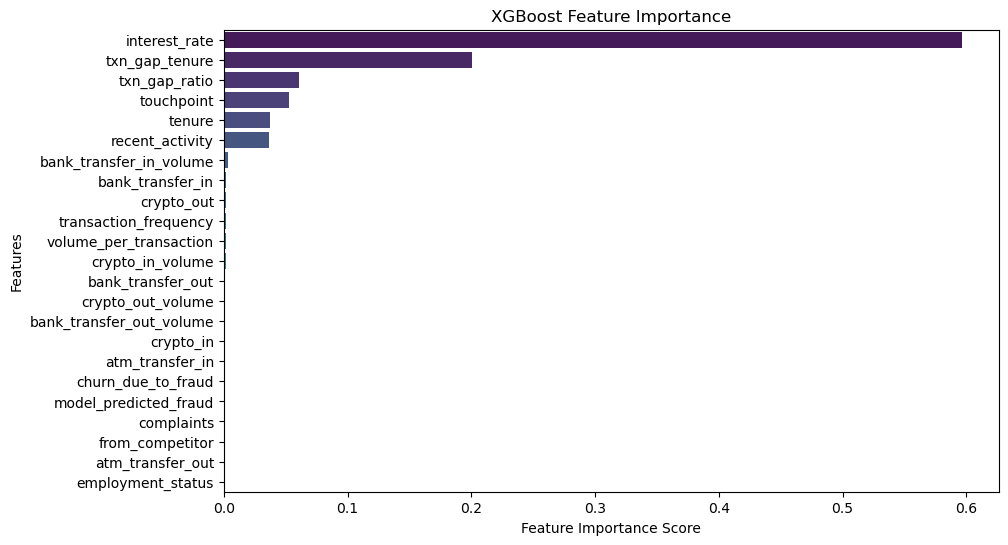

In [139]:
# Get feature importance scores
importance = xgb_model.feature_importances_

# Create DataFrame for better visualization
feature_names = X_train.columns  # Get column names
importance_df = (
    pd.DataFrame({"Feature": feature_names, "Importance": importance})
    .sort_values(by="Importance", ascending=False)
)
print(importance_df)
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("XGBoost Feature Importance")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.show()

##### Dropping the columns with less contribution

In [141]:
xgb_X_train_data = X_train_data.drop(columns = ['atm_transfer_out', 'employment_status', 'complaints', 'from_competitor',
                                     'churn_due_to_fraud', 'model_predicted_fraud'], axis = 1)

In [142]:
xgb_X_train, xgb_X_val, y_train, y_val = train_test_split(xgb_X_train_data, y_train_data, test_size = 0.2, random_state = 22, stratify = y_train_data)

In [143]:
xgb_model_reduced = XGBClassifier(
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Step size shrinkage
    max_depth=3,        # Maximum depth of a tree
    subsample=0.8,      # Fraction of samples used for training each tree
    colsample_bytree=0.8,  # Fraction of features used per tree
    random_state=22
)

xgb_model_reduced.fit(xgb_X_train, y_train)
xgb_train_score_r = xgb_model_reduced.score(xgb_X_train, y_train)
xgb_val_score_r = xgb_model_reduced.score(xgb_X_val, y_val)
print(f' The train score is :{xgb_train_score_r:.3f}, the val score is :{xgb_val_score_r:.3f}')

 The train score is :0.998, the val score is :0.998


##### Training lightgbm and catboost

In [145]:
import lightgbm as lgb
import catboost as ctb

In [146]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=22
)
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 20272, number of negative: 64671
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4304
[LightGBM] [Info] Number of data points in the train set: 84943, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.238654 -> initscore=-1.160072
[LightGBM] [Info] Start training from score -1.160072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

LGBMClassifier(colsample_bytree=0.8, max_depth=3, random_state=22,
               subsample=0.8)

In [147]:
lgb_train_score = lgb_model.score(X_train, y_train)
lgb_val_score = lgb_model.score(X_val, y_val)
print(f'The train score is :{lgb_train_score:.3f}, the val score is :{lgb_val_score:.3f}')

The train score is :0.998, the val score is :0.998


##### Get feature importance scores

                     Feature  Importance
14             txn_gap_ratio         220
15            txn_gap_tenure         216
0              interest_rate         106
12                    tenure          64
7    bank_transfer_in_volume          16
9           crypto_in_volume          13
13                touchpoint          12
17    volume_per_transaction           7
10         crypto_out_volume           7
5                  crypto_in           6
4          bank_transfer_out           5
6                 crypto_out           4
16     transaction_frequency           3
11                complaints           3
1            atm_transfer_in           2
2           atm_transfer_out           2
3           bank_transfer_in           1
8   bank_transfer_out_volume           0
18           recent_activity           0
19           from_competitor           0
20        churn_due_to_fraud           0
21     model_predicted_fraud           0
22         employment_status           0


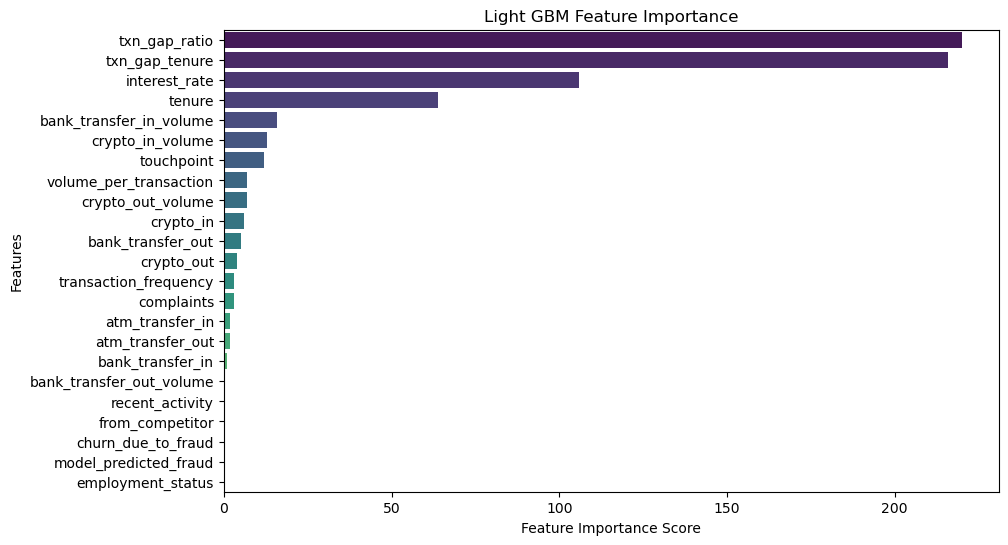

In [149]:
importance = lgb_model.feature_importances_
# Create DataFrame for better visualization
feature_names = X_train.columns  # Get column names
importance_df = (
    pd.DataFrame({"Feature": feature_names, "Importance": importance})
    .sort_values(by="Importance", ascending=False)
)
print(importance_df)
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Light GBM Feature Importance")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")

# Saving the plot
plt.savefig("feature_importance.png", dpi=300, bbox_inches="tight")  # Saves as a high-resolution image
plt.show()

##### Dropping the columns with less contribution

In [151]:
lgb_X_train_data = X_train_data.drop(columns = ['bank_transfer_out_volume', 'employment_status', 'recent_activity', 'from_competitor',
                                     'churn_due_to_fraud', 'model_predicted_fraud'], axis = 1)

In [152]:
lgb_X_train, lgb_X_val, y_train, y_val = train_test_split(lgb_X_train_data, y_train_data, test_size = 0.2, random_state = 22, stratify = y_train_data)

In [153]:
lgb_model_r = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=22
)
lgb_model_r.fit(lgb_X_train, y_train)

[LightGBM] [Info] Number of positive: 20272, number of negative: 64671
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 84943, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.238654 -> initscore=-1.160072
[LightGBM] [Info] Start training from score -1.160072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

LGBMClassifier(colsample_bytree=0.8, max_depth=3, random_state=22,
               subsample=0.8)

In [154]:
lgb_train_score_r = lgb_model_r.score(lgb_X_train, y_train)
lgb_val_score_r = lgb_model_r.score(lgb_X_val, y_val)
print(f'The train score is :{lgb_train_score_r:.3f}, the val score is :{lgb_val_score_r:.3f}')

The train score is :0.998, the val score is :0.998


In [155]:
ctb_model = ctb.CatBoostClassifier(
    iterations=100,  # Number of trees
    learning_rate=0.1,
    depth=3,
    verbose=200,  
    random_state=22
)

ctb_model.fit(X_train, y_train)

0:	learn: 0.4649142	total: 208ms	remaining: 20.6s
99:	learn: 0.0067155	total: 4.24s	remaining: 0us


In [156]:
ctb_train_score = ctb_model.score(X_train, y_train)
ctb_val_score = ctb_model.score(X_val, y_val)
print(f'The train score is :{ctb_train_score:.3f}, the val score is :{ctb_val_score:.3f}')

The train score is :0.998, the val score is :0.998


##### Training with Logistic model

In [158]:
from sklearn.linear_model import LogisticRegression 

In [159]:
lg_model = LogisticRegression(class_weight = 'balanced', random_state = 22, max_iter = 500)
lg_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=500, random_state=22)

In [160]:
lg_train_score = lg_model.score(X_train, y_train)
lg_val_score = lg_model.score(X_val, y_val)
print(f'The train score is :{lg_train_score:.3f}, the val score is :{lg_val_score:.3f}')

The train score is :0.993, the val score is :0.993


##### Classification report and accuracy score for the trained models

In [162]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [163]:
# Make predictions
y_pred_dum = dummy.predict(X_val)  # from dummyclassifier
y_pred_rf = rf_model.predict(X_val)  # From RandomForest
y_pred_rf_r = rf_model_reduced.predict(rf_X_val)  # From RandomForest with reduced features
y_pred_xgb = xgb_model.predict(X_val)  # From XGBoost
y_pred_xgb_r = xgb_model_reduced.predict(xgb_X_val)  # From XGBoost with reduced features
y_pred_lgt = lgb_model.predict(X_val) # from lightgbm
y_pred_lgt_r = lgb_model_r.predict(lgb_X_val) # from lightgbm with reduced features
y_pred_ctb = ctb_model.predict(X_val) # from catboost
y_pred_lg = lg_model.predict(X_val) # from logistic regression
# Compare Accuracy
dum_acc = accuracy_score(y_val, y_pred_dum)
rf_acc = accuracy_score(y_val, y_pred_rf)
rf_acc_r = accuracy_score(y_val, y_pred_rf_r)
xgb_acc = accuracy_score(y_val, y_pred_xgb)
xgb_acc_r = accuracy_score(y_val, y_pred_xgb_r)
lgb_acc = accuracy_score(y_val, y_pred_lgt)
lgb_acc_r = accuracy_score(y_val, y_pred_lgt_r)
ctb_acc = accuracy_score(y_val, y_pred_ctb)
lg_acc = accuracy_score(y_val, y_pred_lg)
print(f"DummyClassifier Accuracy: {dum_acc:.3f}")
print(f"Random Forest Accuracy: {rf_acc:.3f}")
print(f"Random Forest Accuracy with reduced features: {rf_acc_r:.3f}")
print(f"XGBoost Accuracy: {xgb_acc:.3f}")
print(f"XGBoost Accuracy with reduced features: {xgb_acc_r:.3f}")
print(f"LightGBM Accuracy: {lgb_acc:.3f}")
print(f"LightGBM Accuracy with reduced features: {lgb_acc_r:.3f}")
print(f"Catboost Accuracy: {ctb_acc:.3f}")
print(f"Logistic Regression Accuracy: {lg_acc:.3f}")
# Print Classification Reports
print("\nDummyClassifier Classification Report:")
print(classification_report(y_val, y_pred_dum))

print("\nRandom Forest Classification Report:")
print(classification_report(y_val, y_pred_rf))
print("\nRandom Forest Classification Report with reduced features:")
print(classification_report(y_val, y_pred_rf_r))

print("\nXGBoost Classification Report:")
print(classification_report(y_val, y_pred_xgb))
print("\nXGBoost Classification Report with reduced features:")
print(classification_report(y_val, y_pred_xgb_r))

print("\nLightGBM Classification Report:")
print(classification_report(y_val, y_pred_lgt))
print("\nLightGBM Classification Report with reduced features:")
print(classification_report(y_val, y_pred_lgt_r))

print("\nCatboost Classification Report:")
print(classification_report(y_val, y_pred_ctb))

print("\nLogisticRegreesion Classification Report:")
print(classification_report(y_val, y_pred_lg))

DummyClassifier Accuracy: 0.761
Random Forest Accuracy: 0.998
Random Forest Accuracy with reduced features: 0.998
XGBoost Accuracy: 0.998
XGBoost Accuracy with reduced features: 0.998
LightGBM Accuracy: 0.998
LightGBM Accuracy with reduced features: 0.998
Catboost Accuracy: 0.998
Logistic Regression Accuracy: 0.993

DummyClassifier Classification Report:
              precision    recall  f1-score   support

       False       0.76      1.00      0.86     16168
        True       0.00      0.00      0.00      5068

    accuracy                           0.76     21236
   macro avg       0.38      0.50      0.43     21236
weighted avg       0.58      0.76      0.66     21236


Random Forest Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     16168
        True       0.99      1.00      1.00      5068

    accuracy                           1.00     21236
   macro avg       1.00      1.00      1.00     21236
weight

##### Hyperparameter Tunning using Optuna  

In [165]:
#!pip install optuna

In [166]:
import optuna
from sklearn.metrics import roc_auc_score

##### Xgboost tunning 

In [168]:
# Define objective function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10)
    }
    # Train XGBoost
    model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric="logloss", random_state=22)
    model.fit(xgb_X_train, y_train)
    # Predict & calculate ROC-AUC
    y_pred_proba = model.predict_proba(xgb_X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred_proba)   
    return auc_score
# Run optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
# Best parameters
print("Best hyperparameters:", study.best_params)

[I 2025-03-14 13:39:37,649] A new study created in memory with name: no-name-d3f360f5-48f5-48c3-a0de-48c5e7cfe331
[I 2025-03-14 13:39:46,542] Trial 0 finished with value: 0.9999609223516144 and parameters: {'n_estimators': 600, 'learning_rate': 0.1708780476800683, 'max_depth': 3, 'subsample': 0.6134768481152421, 'colsample_bytree': 0.7065025868382858, 'reg_lambda': 2.459756260689583, 'reg_alpha': 3.7044596375184833}. Best is trial 0 with value: 0.9999609223516144.
[I 2025-03-14 13:39:54,397] Trial 1 finished with value: 0.9999683546713728 and parameters: {'n_estimators': 400, 'learning_rate': 0.09193030839479482, 'max_depth': 6, 'subsample': 0.9022282961308437, 'colsample_bytree': 0.7516117871269008, 'reg_lambda': 1.514383913364588, 'reg_alpha': 3.756337819607448}. Best is trial 1 with value: 0.9999683546713728.
[I 2025-03-14 13:40:04,462] Trial 2 finished with value: 0.999961794947448 and parameters: {'n_estimators': 900, 'learning_rate': 0.2463795850642644, 'max_depth': 12, 'subsampl

Best hyperparameters: {'n_estimators': 700, 'learning_rate': 0.08915632329050249, 'max_depth': 9, 'subsample': 0.8621748471292383, 'colsample_bytree': 0.9903369501395662, 'reg_lambda': 4.121947323021743, 'reg_alpha': 2.2985460535748254}


##### Fitting the best params for Xgboost

In [170]:
best_params = study.best_params
xgb_model_1 = XGBClassifier(**best_params, use_label_encoder = False, eval_metric = 'logloss', random_state = 22)
xgb_model_1.fit(xgb_X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9903369501395662, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08915632329050249,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=700, n_jobs=None,
              num_parallel_tree=None, random_state=22, ...)

In [171]:
xgb_train_score_1 = xgb_model_1.score(xgb_X_train, y_train)
xgb_val_score_1 = xgb_model_1.score(xgb_X_val, y_val)
print(f' The train score is :{xgb_train_score_1:.3f}, the val score is :{xgb_val_score_1:.3f}')

 The train score is :1.000, the val score is :0.998


In [172]:
print("\nXGBoost Classification Report with reduced features:")
print(classification_report(y_val, y_pred_xgb_r))

print("\Tuned XGBoost Classification Report:")
print(classification_report(y_val, (xgb_model_1.predict(xgb_X_val))))


XGBoost Classification Report with reduced features:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     16168
        True       0.99      1.00      1.00      5068

    accuracy                           1.00     21236
   macro avg       1.00      1.00      1.00     21236
weighted avg       1.00      1.00      1.00     21236

\Tuned XGBoost Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     16168
        True       1.00      1.00      1.00      5068

    accuracy                           1.00     21236
   macro avg       1.00      1.00      1.00     21236
weighted avg       1.00      1.00      1.00     21236



##### Tuning RandomForest model, my dataset is large so i'll sample 20%, use cross_val_score to validate the best params

In [174]:
from sklearn.model_selection import cross_val_score

In [175]:
from sklearn.utils import resample

In [176]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 150, step=50)  # Reduce upper limit
    max_depth = trial.suggest_int("max_depth", 5, 20, step=5)  # Reduce search space
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight="balanced",
        random_state=22,
        n_jobs=-1
    )
    # Train on a subset (20% of data)
    X_sample, y_sample = resample(rf_X_train, y_train, n_samples=int(len(rf_X_train) * 0.2), random_state=42)
    score = cross_val_score(rf, X_sample, y_sample, cv=3, scoring="roc_auc").mean()
    return score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, timeout=1800)  # 10 trials OR max 30 mins

print("Best parameters:", study.best_params)

[I 2025-03-14 13:42:53,941] A new study created in memory with name: no-name-77d2c8b8-31e2-4380-9288-67b9412526e0
[I 2025-03-14 13:43:01,747] Trial 0 finished with value: 0.9997052686613929 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9997052686613929.
[I 2025-03-14 13:43:04,729] Trial 1 finished with value: 0.9999038708789644 and parameters: {'n_estimators': 50, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.9999038708789644.
[I 2025-03-14 13:43:10,907] Trial 2 finished with value: 0.9998978902788188 and parameters: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9999038708789644.
[I 2025-03-14 13:43:16,072] Trial 3 finished with value: 0.9997109765057332 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 1 with value: 0

Best parameters: {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 2}


In [177]:
rf_model_tune = RandomForestClassifier(n_estimators = 50, max_depth = 15, min_samples_split = 9, min_samples_leaf = 3, random_state = 22)
rf_model_tune.fit(rf_X_train, y_train)
rf_train_score_tune = rf_model_tune.score(rf_X_train, y_train)
rf_val_score_tune = rf_model_tune.score(rf_X_val, y_val)
print(f'The train score is :{rf_train_score_tune:.3f}, and the val score is :{rf_val_score_tune:.3f}')

The train score is :0.999, and the val score is :0.998


In [178]:
print("\nRandomForest Classification Report with reduced features:")
print(classification_report(y_val, y_pred_rf_r))

print("\Tuned RandomForest Classification Report:")
print(classification_report(y_val, (rf_model_tune.predict(rf_X_val))))


RandomForest Classification Report with reduced features:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     16168
        True       0.99      1.00      1.00      5068

    accuracy                           1.00     21236
   macro avg       1.00      1.00      1.00     21236
weighted avg       1.00      1.00      1.00     21236

\Tuned RandomForest Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     16168
        True       0.99      1.00      1.00      5068

    accuracy                           1.00     21236
   macro avg       1.00      1.00      1.00     21236
weighted avg       1.00      1.00      1.00     21236



## ANALYSIS ON TEST SET 

In [180]:
# importing the test data
test_file = pd.read_parquet('test.parquet')
test_file.sample(3)

,Id,customer_id,interest_rate,name,country,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,...,crypto_out_volume,complaints,touchpoints,csat_scores,tenure,from_competitor,job,churn_due_to_fraud,Usage,model_predicted_fraud
858646,7045966,97736,3.5,Richard Lewis,Finland,1959-12-06,"34083 Watson Tunnel Suite 764\nJacksonport, MP...",2025-09-09,0,0,...,17.004462,0,[],"{'appointment': None, 'email': None, 'phone': ...",824,False,"Accountant, chartered management",False,Private,False
396280,6583600,75317,3.0,Christine Johnson,Norway,1942-01-24,"105 Jared Center Apt. 569\nRobertstad, MS 5269...",2024-10-30,0,0,...,24.602443,0,[],"{'appointment': None, 'email': None, 'phone': ...",1188,False,unemployed,False,Private,False
317199,6504519,100990,3.0,Larry Barnes,Estonia,1972-01-23,Unit 6489 Box 6496\nDPO AA 11045 Estonia,2024-09-01,0,0,...,239.440752,0,[],"{'appointment': None, 'email': None, 'phone': ...",371,False,Secretary/administrator,False,Private,False


In [458]:
test_file[test_file['customer_id'] == 1]

,Id,customer_id,interest_rate,name,country,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,...,crypto_out_volume,complaints,touchpoints,csat_scores,tenure,from_competitor,job,churn_due_to_fraud,Usage,model_predicted_fraud
1097087,7284407,1,0.0,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2026-02-27,0,0,...,213.615319,0,[],"{'appointment': None, 'email': None, 'phone': ...",5398,False,Amenity horticulturist,False,Public,False


## EDA

##### Data Inspection and exploration will be as it was done on the training dataset 

In [183]:
test_file.shape

(1360472, 27)

In [184]:
test_file['customer_id'].nunique()

165155

In [185]:
test_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1360472 entries, 0 to 1360471
Data columns (total 27 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   Id                        1360472 non-null  int64         
 1   customer_id               1360472 non-null  int64         
 2   interest_rate             1360472 non-null  float64       
 3   name                      1360472 non-null  object        
 4   country                   1360472 non-null  object        
 5   date_of_birth             1360472 non-null  object        
 6   address                   1360472 non-null  object        
 7   date                      1360472 non-null  datetime64[ns]
 8   atm_transfer_in           1360472 non-null  int64         
 9   atm_transfer_out          1360472 non-null  int64         
 10  bank_transfer_in          1360472 non-null  int64         
 11  bank_transfer_out         1360472 non-null  int64 

In [186]:
test_file[['touchpoints', 'csat_scores']].sample(2)

,touchpoints,csat_scores
577715,[],"{'appointment': None, 'email': None, 'phone': ..."
891863,[],"{'appointment': None, 'email': None, 'phone': ..."


##### Extracting the values from the tounchpoint column

In [188]:
# extracting the values from the tounchpoint column
test_file_exploded = test_file.explode("touchpoints")
# Count occurrences efficiently
touchpoint_counts = test_file_exploded.groupby(test_file_exploded.index)["touchpoints"].value_counts().unstack(fill_value=0)
test_file_new = test_file.drop(columns=['touchpoints']).join(touchpoint_counts)
test_file_new.sample(2)

,Id,customer_id,interest_rate,name,country,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,...,tenure,from_competitor,job,churn_due_to_fraud,Usage,model_predicted_fraud,appointment,email,phone,whatsapp
422823,6610143,65409,3.0,Melissa Thompson,Switzerland,1992-12-17,"5630 Amanda View Apt. 037\nJonesshire, LA 5313...",2024-11-19,0,0,...,1511,False,Electronics engineer,False,Private,False,2.0,0.0,0.0,0.0
223420,6410740,83546,3.0,Ruben Lee,Romania,1955-09-02,"1821 Samantha Coves Suite 930\nRichardburgh, C...",2024-06-22,0,0,...,771,False,Chief Financial Officer,False,Private,False,NaN,NaN,NaN,NaN


In [189]:
test_file_new['touchpoint'] = test_file_new[['appointment', 'email', 'whatsapp', 'phone']].sum(axis = 1)
test_file_new.drop(columns = ['appointment', 'email', 'whatsapp', 'phone'], inplace = True)

##### Extracting values from csat score

In [191]:
# Need to extract the key and values in the csat_scores dictionary column, this code creates a column that have the calculated mean of each customer satisfaction
test_file_new["avg_csat_score"] = test_file_new["csat_scores"].apply(
    lambda x: np.mean([v for v in x.values() if v is not None]) 
    if isinstance(x, dict) and any(v is not None for v in x.values()) else np.nan
)

In [192]:
# filling the none values with 0
test_file_new['avg_csat_score'].isna().mean()

0.981481427034147

##### Getting the datetime column ready for my analysis

In [194]:
test_file_new['year'] = pd.to_datetime(test_file_new['date']).dt.year
test_file_new['month'] = pd.to_datetime(test_file_new['date']).dt.month
test_file_new['weekday'] = pd.to_datetime(test_file_new['date']).dt.weekday

##### Exploring job column and feature engineering

In [196]:
test_file_new['job'].value_counts()

job
unemployed                            249185
Interpreter                             2230
Research scientist (medical)            2168
Insurance account manager               2159
Medical physicist                       2158
                                       ...  
Museum/gallery exhibitions officer      1377
Engineer, building services             1365
Chief Executive Officer                 1332
Community development worker            1269
Politician's assistant                  1240
Name: count, Length: 640, dtype: int64

##### My data is too large and the number of nunique job is 640, using get_dummies will create too many columns and my computer memory can't run that

In [198]:
unemployed_keyword = ['unemployed']
test_file_new['employment_status'] = test_file_new['job'].apply(
    lambda x: 'unemployed' if pd.isna(x) or any(word in x for word in unemployed_keyword) else 'employed'
)
test_file_new['employment_status'] = test_file_new['employment_status'].map({'employed': 1, 'unemployed': 0})
test_file_new.drop(columns = ['job'], inplace = True)

##### this usage is a new column, i need to explore the values and would drop it because it isn't in my train data

In [200]:
test_file_new['Usage'].value_counts()

Usage
Private    1331193
Public       29279
Name: count, dtype: int64

In [201]:
test_file_new.sample(2)

,Id,customer_id,interest_rate,name,country,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,...,from_competitor,churn_due_to_fraud,Usage,model_predicted_fraud,touchpoint,avg_csat_score,year,month,weekday,employment_status
588899,6776219,27953,3.5,Tina Smith,Latvia,1967-12-07,Unit 9835 Box 2353\nDPO AA 54173 Latvia,2025-03-16,0,0,...,False,False,Private,False,0.0,NaN,2025,3,6,1
1202204,7389524,112865,0.0,Tracy Vargas,Belgium,1945-09-17,"241 Young Loop Suite 230\nKennethshire, ME 876...",2026-06-04,0,0,...,False,False,Private,False,0.0,NaN,2026,6,3,1


##### Now i will drop columns that are not on the trained models

In [203]:

test_file_main = test_file_new.drop(columns = ['Id', 'name', 'country', 'address', 'date_of_birth','avg_csat_score', 'Usage' , 'csat_scores'], axis = 1)

In [204]:
test_file_main.shape

(1360472, 23)

In [205]:
test_file_main.isna().sum()

customer_id                 0
interest_rate               0
date                        0
atm_transfer_in             0
atm_transfer_out            0
bank_transfer_in            0
bank_transfer_out           0
crypto_in                   0
crypto_out                  0
bank_transfer_in_volume     0
bank_transfer_out_volume    0
crypto_in_volume            0
crypto_out_volume           0
complaints                  0
tenure                      0
from_competitor             0
churn_due_to_fraud          0
model_predicted_fraud       0
touchpoint                  0
year                        0
month                       0
weekday                     0
employment_status           0
dtype: int64

In [206]:
test_file_main.duplicated().sum()

0

##### Aggregating the time series data

In [208]:
customer_test_data = test_file_main.groupby('customer_id').agg({
    'interest_rate': 'mean',
    'atm_transfer_in': 'sum',
    'atm_transfer_out': 'sum',
    'bank_transfer_in': 'sum',
    'bank_transfer_out': 'sum',
    'crypto_in': 'sum',
    'crypto_out': 'sum',
    'bank_transfer_in_volume': 'sum',
    'bank_transfer_out_volume': 'sum',
    'crypto_in_volume': 'sum',
    'crypto_out_volume': 'sum',
    'complaints': 'sum',
    'tenure': 'max',
    'from_competitor': 'first',
    'churn_due_to_fraud': 'max',
    'model_predicted_fraud': 'max',
    'touchpoint': 'sum',
    'employment_status': 'max',
    'year': 'max',
    'month': 'max',
    'weekday': 'max',
    'date': 'max'
}).reset_index()

In [209]:
customer_test_data.sample(2)

,customer_id,interest_rate,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,...,tenure,from_competitor,churn_due_to_fraud,model_predicted_fraud,touchpoint,employment_status,year,month,weekday,date
143550,143572,3.500000,0,0,8917,13604,127,42,20789.806648,16235.793941,...,3,False,False,False,0.0,1,2025,11,5,2025-11-29
17186,17189,2.708333,0,0,32389,25264,294,74,109931.384168,79248.384827,...,4181,False,False,False,6.0,1,2026,7,6,2026-07-15


##### Feature Engineering as it was done on the training dataset

In [211]:
def feature_engineering(customer_test_data):
    
    customer_test_data['utc_datetime'] = pd.to_datetime(customer_test_data['date'], utc=True)    
    
    last_date_1 = customer_test_data['utc_datetime'].max()    
    # Days since last transaction
    customer_test_data['days_since_last_txn'] = (last_date_1 - customer_test_data['utc_datetime']).dt.days    
    # Interaction Features
    customer_test_data['txn_gap_ratio'] = customer_test_data['days_since_last_txn'] / (customer_test_data['tenure'] + 1)  # Avoid division by zero
    customer_test_data['txn_gap_tenure'] = customer_test_data['days_since_last_txn'] * customer_test_data['tenure']    
    # Velocity Features
    customer_test_data['transaction_frequency'] = (customer_test_data['bank_transfer_in'] + customer_test_data['bank_transfer_out'] +
                                              customer_test_data['crypto_in'] + customer_test_data['crypto_out']) / (customer_test_data['tenure'] + 1)
    
    customer_test_data['volume_per_transaction'] = (customer_test_data['bank_transfer_in_volume'] + customer_test_data['bank_transfer_out_volume'] +
                                               customer_test_data['crypto_in_volume'] + customer_test_data['crypto_out_volume']) / \
                                              (customer_test_data['bank_transfer_in'] + customer_test_data['bank_transfer_out'] +
                                               customer_test_data['crypto_in'] + customer_test_data['crypto_out'] + 1)   
    # Recent Activity Features 
    customer_test_data['recent_activity'] = (customer_test_data['days_since_last_txn'] <= 90).astype(int)  # Active in last 90 days    
    return customer_test_data
# Apply feature engineering
customer_test_data = feature_engineering(customer_test_data)
# Previewing the updated dataset
customer_test_data.sample(3)

,customer_id,interest_rate,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,...,month,weekday,date,utc_datetime,days_since_last_txn,txn_gap_ratio,txn_gap_tenure,transaction_frequency,volume_per_transaction,recent_activity
124279,124290,2.111111,0,0,20,3726,38,18,3575.676175,232.159297,...,12,6,2026-01-27,2026-01-27 00:00:00+00:00,338,0.853535,133510,9.601010,1.192405,0
59437,59441,0.000000,0,0,3199,10,4,7,5262.615025,185.152854,...,8,1,2025-08-26,2025-08-26 00:00:00+00:00,492,1.312000,184008,8.586667,1.794987,0
158390,158516,0.000000,0,0,35,2,1,1,1125.309068,20.899434,...,7,1,2026-07-14,2026-07-14 00:00:00+00:00,170,170.000000,0,39.000000,28.827407,0


##### Churn define before testing the model

In [213]:
threshold_days = 365
customer_test_data['churn'] = customer_test_data['days_since_last_txn'] > threshold_days
customer_test_data.sample(2)

,customer_id,interest_rate,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,...,weekday,date,utc_datetime,days_since_last_txn,txn_gap_ratio,txn_gap_tenure,transaction_frequency,volume_per_transaction,recent_activity,churn
16315,16318,3.000000,0,0,1984,8,4,4,6436.515060,959.122068,...,5,2024-02-20,2024-02-20 00:00:00+00:00,1045,0.307082,3555090,0.587717,3.986617,0,True
120938,120949,3.478261,0,0,63,48,23,23,3127.356021,794.427153,...,6,2025-12-03,2025-12-03 00:00:00+00:00,393,0.963235,159951,0.384804,44.725376,0,True


In [214]:
customer_test_data.describe().round(3)

,customer_id,interest_rate,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,...,year,month,weekday,date,days_since_last_txn,txn_gap_ratio,txn_gap_tenure,transaction_frequency,volume_per_transaction,recent_activity
count,165155.000,165155.000,165155.000,165155.000,165155.000,165155.000,165155.000,165155.000,165155.000,165155.000,...,165155.000,165155.000,165155.000,165155,165155.000,165155.000,165155.000,165155.000,165155.000,165155.000
mean,82595.245,1.943,1.929,1.594,11690.903,8688.030,89.742,31.558,20583.751,13916.925,...,2025.569,6.837,5.009,2026-01-25 01:28:57.124519424,339.938,16.645,477342.905,321.137,20.717,0.068
min,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,17.967,8.894,...,2024.000,1.000,0.000,2024-01-01 00:00:00,0.000,0.000,0.000,0.001,0.034,0.000
25%,41292.500,0.000,0.000,0.000,28.000,12.000,6.000,6.000,2101.118,220.104,...,2025.000,4.000,5.000,2025-11-19 00:00:00,173.000,0.130,88692.000,0.484,1.791,0.000
50%,82584.000,2.500,0.000,0.000,2172.000,38.000,14.000,14.000,6883.858,715.492,...,2026.000,7.000,6.000,2026-03-19 00:00:00,287.000,0.291,271860.000,5.432,2.933,0.000
75%,123876.500,3.000,0.000,0.000,11628.000,9390.000,98.000,37.000,22804.408,14211.578,...,2026.000,10.000,6.000,2026-07-11 00:00:00,407.000,0.860,639160.000,27.557,10.378,0.000
max,165324.000,3.500,22154.000,19472.000,887093.000,494274.000,3328.000,1318.000,635910.816,524861.344,...,2026.000,12.000,6.000,2026-12-31 00:00:00,1095.000,1094.000,6286854.000,36957.500,980.385,1.000
std,47697.377,1.276,129.505,106.532,26371.840,20484.779,175.371,48.279,34698.397,29242.423,...,0.664,3.379,1.662,NaN,236.285,57.214,623158.148,2235.299,44.204,0.253


##### Data distribution visaulization 

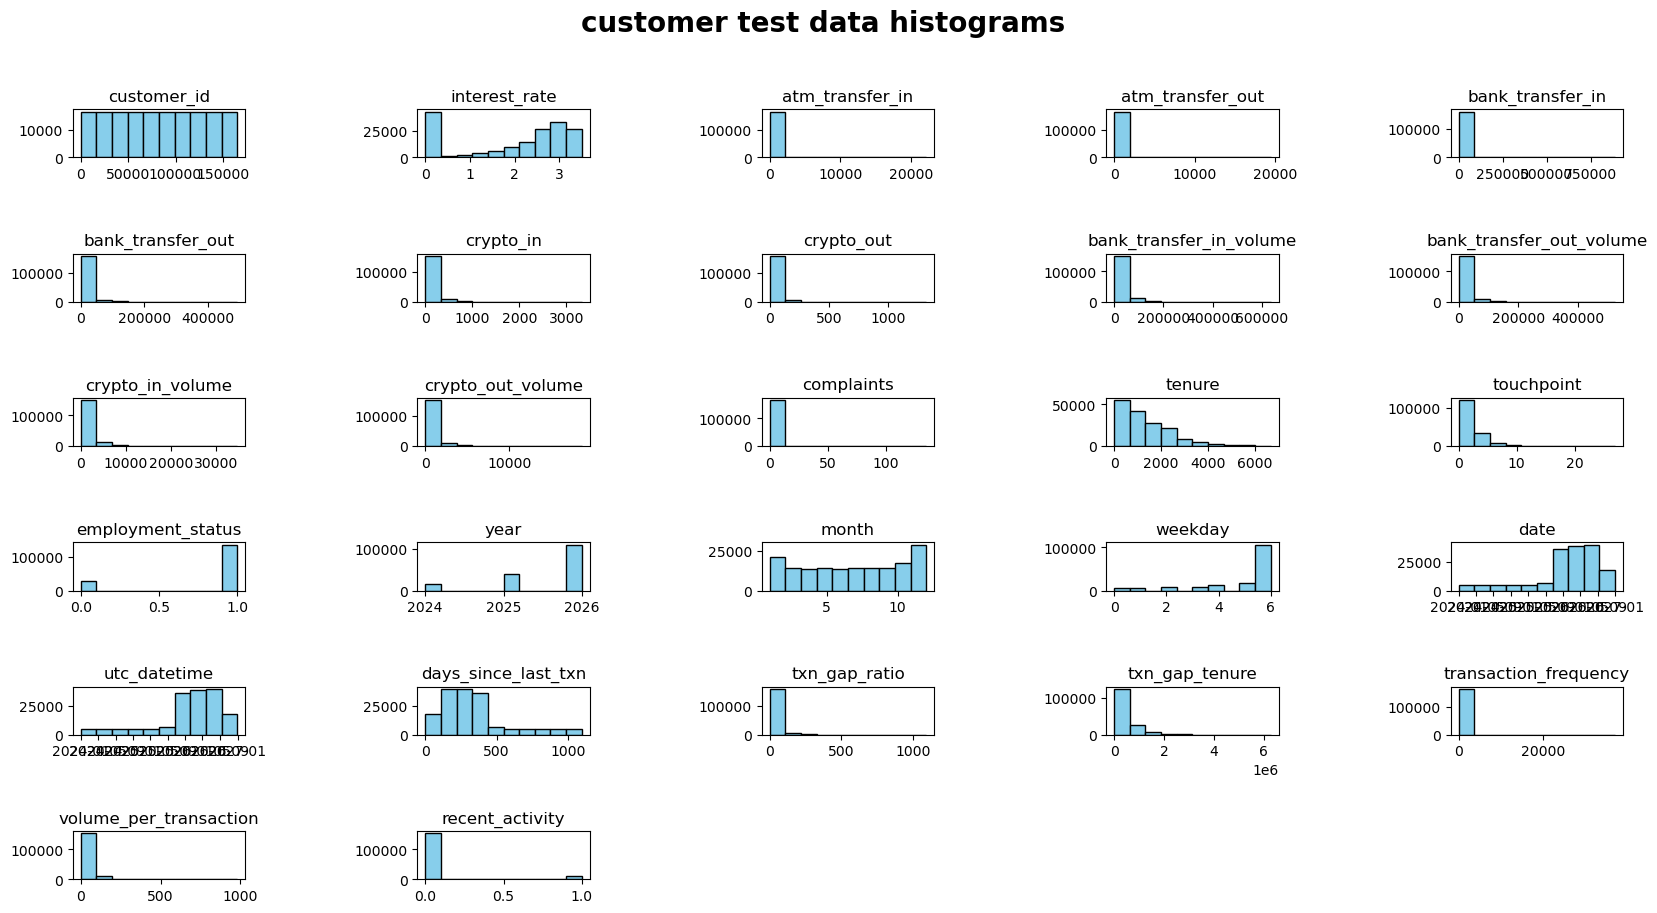

In [216]:
customer_test_data.hist(figsize = (20, 10), grid = False, color = 'skyblue', edgecolor = 'black')
plt.subplots_adjust(hspace = 2.0, wspace = 1.0)
plt.suptitle('customer test data histograms', fontsize=20, fontweight= 'bold')
plt.show();


##### Correlation 

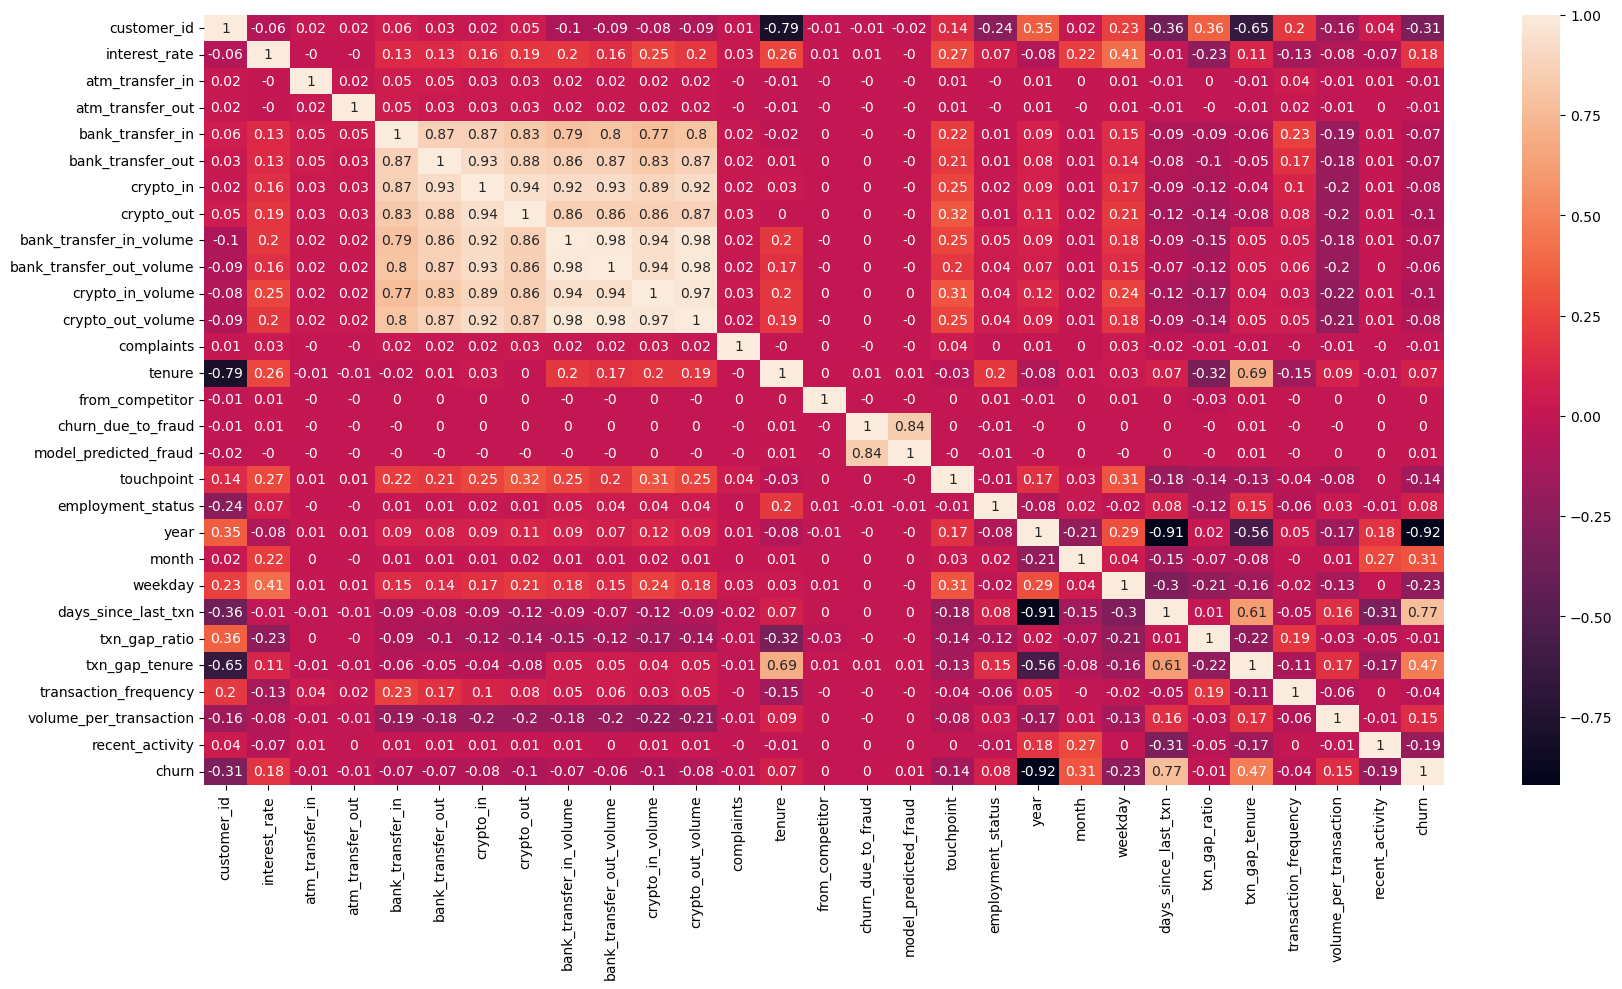

In [218]:
corr = customer_test_data.corr(numeric_only = True).round(2)
plt.figure(figsize = (20,10))
sns.heatmap(corr, annot = True);

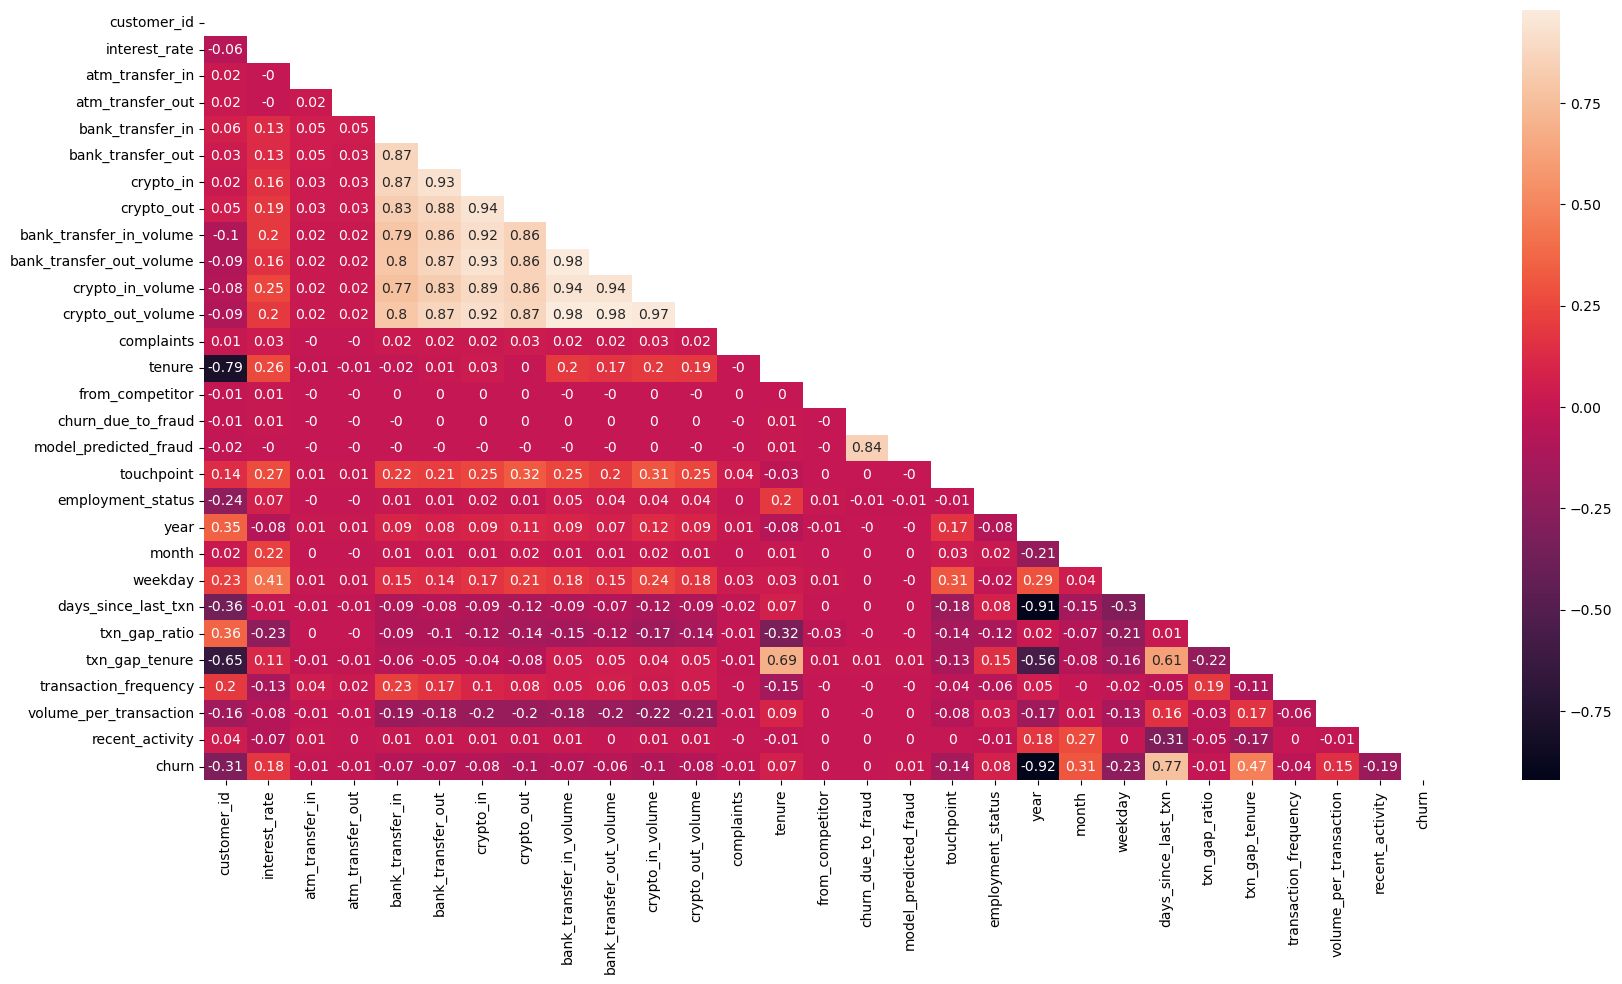

In [219]:
mask = np.triu(np.ones_like(customer_test_data.corr(numeric_only = True).round(2)))
plt.figure(figsize = (20, 10))
sns.heatmap(corr, annot = True, mask = mask);

In [220]:
customer_test_data['churn'].value_counts(normalize = True).round(3)

churn
False    0.669
True     0.331
Name: proportion, dtype: float64

### Testing our model on this data

##### Will drop the columns that isn't in our trained model

In [223]:
test_data_main = customer_test_data.drop(columns = ['date', 'days_since_last_txn', 'utc_datetime', 'year', 'month', 'weekday'], axis = 1)

In [224]:
X_test = test_data_main.drop(columns = ['churn', 'customer_id', 'employment_status', 'churn_due_to_fraud', 'model_predicted_fraud',
                                              'from_competitor'], axis = 1 )

In [225]:
y_test = test_data_main['churn']

In [226]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)

In [227]:
X_test_complete = pd.concat([X_test_scaled, test_data_main[['from_competitor', 'churn_due_to_fraud', 'model_predicted_fraud', 
                                                                  'employment_status'
                                                                  ]].reset_index(drop = True)], axis = 1)

##### Checking that the test columns is in same order with the train columns

In [229]:
train_features = X_train.columns  # Get original feature names
X_test_complete = X_test_complete[train_features]

##### Predict using the trained XGBoost model

In [231]:
xgb_y_test_pred = xgb_model.predict(X_test_complete)
# Converting predictions into a DataFrame
test_data_main['xgb_churn_prediction'] = xgb_y_test_pred
# Display predictions
test_data_main[['xgb_churn_prediction', 'churn']].sample(3)

,xgb_churn_prediction,churn
68096,1,True
141910,0,True
37165,0,False


In [232]:
xgb_X_test = X_test_complete.drop(columns = ['atm_transfer_out', 'employment_status', 'complaints', 'from_competitor',
                                     'churn_due_to_fraud', 'model_predicted_fraud'], axis = 1)

In [233]:
r_xgb_y_test_pred = xgb_model_reduced.predict(xgb_X_test)
# Converting predictions into a DataFrame
test_data_main['reduced_xgb_churn_prediction'] = r_xgb_y_test_pred
# Display predictions
test_data_main[['reduced_xgb_churn_prediction', 'churn']].sample(3)

,reduced_xgb_churn_prediction,churn
89872,0,True
52125,0,False
88278,1,True


In [234]:
t_xgb_y_test_pred = xgb_model_1.predict(xgb_X_test)
# Converting predictions into a DataFrame
test_data_main['tuned_xgb_churn_prediction'] = t_xgb_y_test_pred
# Display predictions
test_data_main[['tuned_xgb_churn_prediction', 'churn']].sample(3)

,tuned_xgb_churn_prediction,churn
1207,0,False
135942,0,False
19562,1,True


##### Predict using the trained RandomForest model

In [236]:
rf_y_test_pred = rf_model.predict(X_test_complete)
test_data_main['rf_churn_prediction'] = rf_y_test_pred
test_data_main[['rf_churn_prediction', 'churn']].sample(3)

,rf_churn_prediction,churn
139145,False,False
17605,True,True
3611,True,True


In [237]:
rf_X_test = X_test_complete.drop(columns = ['employment_status', 'atm_transfer_out', 'atm_transfer_in', 'complaints', 'from_competitor',
                                     'churn_due_to_fraud', 'model_predicted_fraud'], axis = 1)

In [238]:
r_rf_y_test_pred = rf_model_reduced.predict(rf_X_test)
test_data_main['reduced_rf_churn_prediction'] = r_rf_y_test_pred
test_data_main[['reduced_rf_churn_prediction', 'churn']].sample(3)

,reduced_rf_churn_prediction,churn
17445,False,False
145473,True,False
66974,True,True


In [239]:
t_rf_y_test_pred = rf_model_tune.predict(rf_X_test)
test_data_main['tuned_rf_churn_prediction'] = t_rf_y_test_pred
test_data_main[['tuned_rf_churn_prediction', 'churn']].sample(3)

,tuned_rf_churn_prediction,churn
110671,False,False
39770,False,False
45494,False,True


##### Predicting using the trained Lightgbm model

In [241]:
lgb_y_test_pred = lgb_model.predict(X_test_complete)
test_data_main['lgb_churn_prediction'] = lgb_y_test_pred
test_data_main[['lgb_churn_prediction', 'churn']].sample(3)

,lgb_churn_prediction,churn
146403,True,False
31604,True,True
163531,True,False


In [242]:
lgb_X_test = X_test_complete.drop(columns = ['bank_transfer_out_volume', 'employment_status', 'recent_activity', 'from_competitor',
                                     'churn_due_to_fraud', 'model_predicted_fraud'], axis = 1)

In [243]:
r_lgb_y_test_pred = lgb_model_r.predict(lgb_X_test)
test_data_main['r_lgb_churn_prediction'] = r_lgb_y_test_pred
test_data_main[['r_lgb_churn_prediction', 'churn']].sample(3)

,r_lgb_churn_prediction,churn
30222,True,True
31942,True,True
85191,True,True


##### Predicting using trained Catboost model

In [245]:
ctb_y_test_pred = ctb_model.predict(X_test_complete)
test_data_main['ctb_churn_prediction'] = ctb_y_test_pred
test_data_main[['ctb_churn_prediction', 'churn']].sample(3)

,ctb_churn_prediction,churn
139202,False,False
76177,False,False
60421,False,False


## Evaluation 

##### Using classification report, confusion metrics and ROU-AUC for to evalute the model performance

In [248]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve

##### For RandomForest

In [250]:
# Classification report
print('classification report RandomForest')
print(classification_report(y_test, r_rf_y_test_pred))

print('classification report RandomForest tuned')
print(classification_report(y_test, t_rf_y_test_pred))
# ROC-AUC Score
roc_auc = roc_auc_score(y_test, r_rf_y_test_pred)
print("ROC-AUC Score RandomeForest:", roc_auc)

roc_auc = roc_auc_score(y_test, t_rf_y_test_pred)
print("ROC-AUC Score RandomeForest tuned:", roc_auc)

classification report RandomForest
              precision    recall  f1-score   support

       False       0.90      0.78      0.84    110479
        True       0.65      0.83      0.73     54676

    accuracy                           0.80    165155
   macro avg       0.78      0.80      0.78    165155
weighted avg       0.82      0.80      0.80    165155

classification report RandomForest tuned
              precision    recall  f1-score   support

       False       0.87      0.77      0.82    110479
        True       0.62      0.77      0.69     54676

    accuracy                           0.77    165155
   macro avg       0.75      0.77      0.75    165155
weighted avg       0.79      0.77      0.77    165155

ROC-AUC Score RandomeForest: 0.8044266367578483
ROC-AUC Score RandomeForest tuned: 0.77056494674007


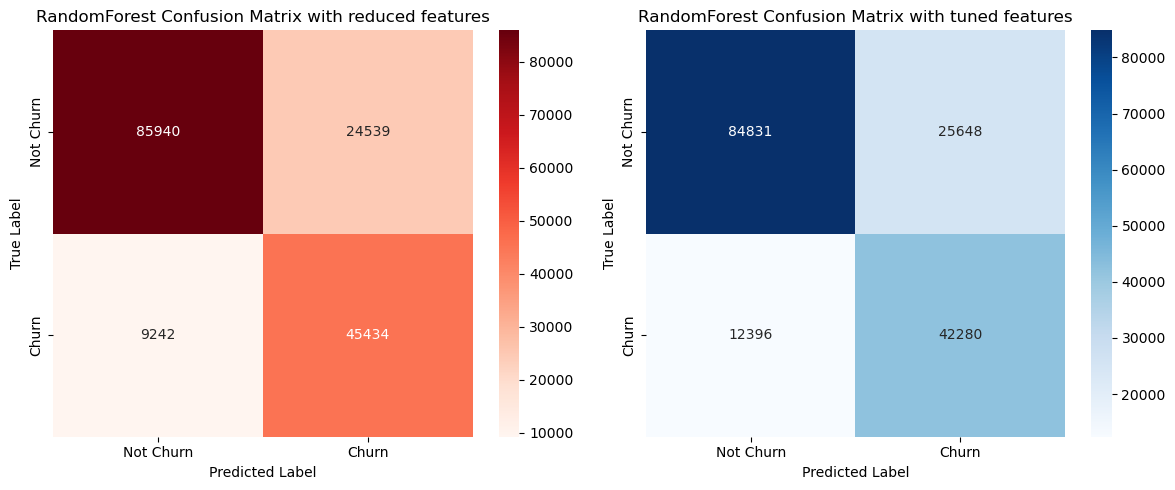

In [251]:
cm_rf = confusion_matrix(y_test, r_rf_y_test_pred)  
cm_rf_t = confusion_matrix(y_test, t_rf_y_test_pred)  
# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
# Ploting RandomForest Confusion Matrix with reduced feature
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Reds", xticklabels=["Not Churn", "Churn"], yticklabels=["Not Churn", "Churn"], ax=axes[0])
axes[0].set_title("RandomForest Confusion Matrix with reduced features")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")
# Ploting RandomForest Confusion Matrix with tuned feature
sns.heatmap(cm_rf_t, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Churn", "Churn"], yticklabels=["Not Churn", "Churn"], ax=axes[1])
axes[1].set_title("RandomForest Confusion Matrix with tuned features")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")
# Adjust layout
plt.tight_layout()
plt.show()

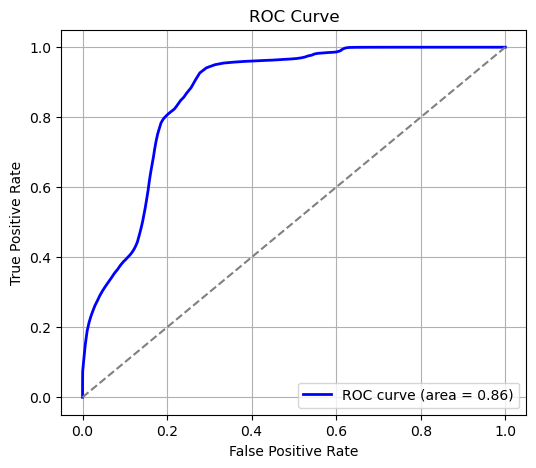

In [252]:
from sklearn.metrics import roc_curve, auc
# Get predicted probabilities
rf_y_test_proba = rf_model_reduced.predict_proba(rf_X_test)[:, 1]  # Use probability of positive class
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, rf_y_test_proba)
roc_auc = auc(fpr, tpr)
# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

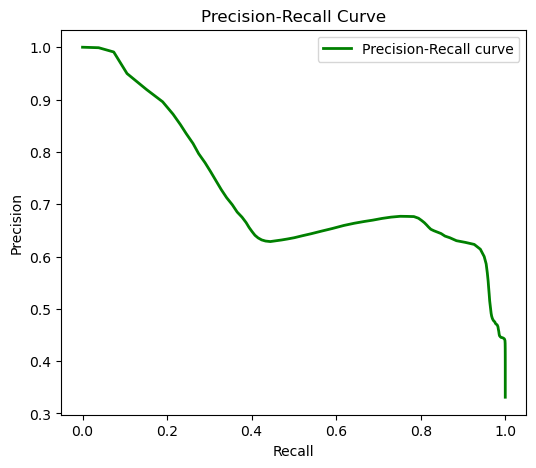

In [253]:
from sklearn.metrics import precision_recall_curve

# Compute Precision-Recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, rf_y_test_proba)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, color="green", lw=2, label="Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

##### For Xgboost

In [255]:
# Classification report
print('classification report Xgboost')
print(classification_report(y_test, r_xgb_y_test_pred))

print('classification report Xgboost tuned')
print(classification_report(y_test, t_xgb_y_test_pred))
# ROC-AUC Score
roc_auc = roc_auc_score(y_test, r_xgb_y_test_pred)
print("ROC-AUC Score Xgboost:", roc_auc)

roc_auc = roc_auc_score(y_test, t_xgb_y_test_pred)
print("ROC-AUC Score Xgboost tuned:", roc_auc)

classification report Xgboost
              precision    recall  f1-score   support

       False       0.93      0.80      0.86    110479
        True       0.68      0.88      0.77     54676

    accuracy                           0.83    165155
   macro avg       0.81      0.84      0.81    165155
weighted avg       0.85      0.83      0.83    165155

classification report Xgboost tuned
              precision    recall  f1-score   support

       False       0.93      0.82      0.87    110479
        True       0.71      0.87      0.78     54676

    accuracy                           0.84    165155
   macro avg       0.82      0.85      0.83    165155
weighted avg       0.86      0.84      0.84    165155

ROC-AUC Score Xgboost: 0.8393290729335076
ROC-AUC Score Xgboost tuned: 0.8464479987590215


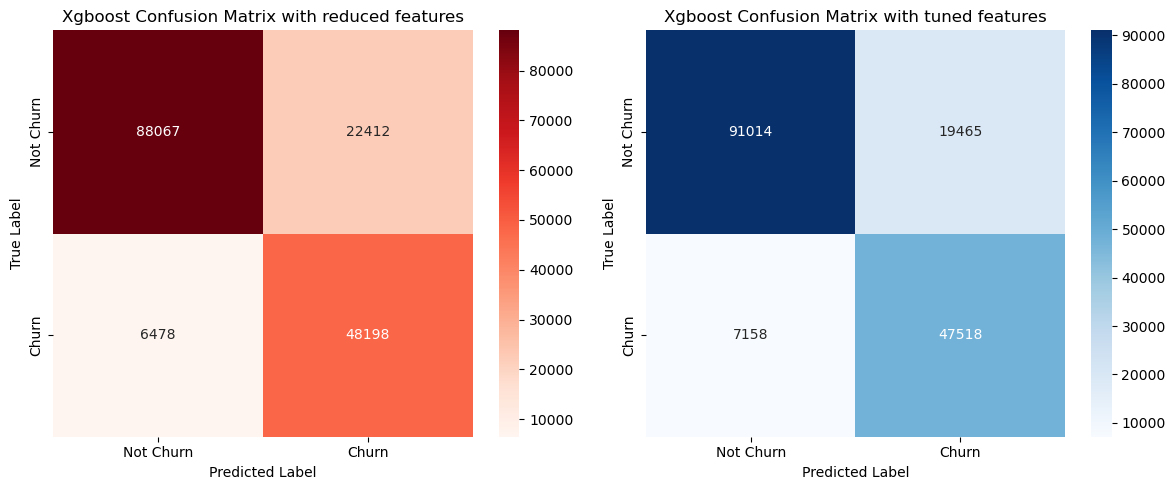

In [256]:
cm_xgb = confusion_matrix(y_test, r_xgb_y_test_pred)  
cm_xgb_t = confusion_matrix(y_test, t_xgb_y_test_pred)  
# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
# Ploting RandomForest Confusion Matrix with reduced feature
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Reds", xticklabels=["Not Churn", "Churn"], yticklabels=["Not Churn", "Churn"], ax=axes[0])
axes[0].set_title("Xgboost Confusion Matrix with reduced features")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")
# Ploting RandomForest Confusion Matrix with tuned feature
sns.heatmap(cm_xgb_t, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Churn", "Churn"], yticklabels=["Not Churn", "Churn"], ax=axes[1])
axes[1].set_title("Xgboost Confusion Matrix with tuned features")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")
# Adjust layout
plt.tight_layout()
plt.show()

##### For LightGbm

In [258]:
# Classification report
print('classification report Lightgbm')
print(classification_report(y_test, r_lgb_y_test_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, r_lgb_y_test_pred)
print("ROC-AUC Score Lightgbm:", roc_auc)

classification report Lightgbm
              precision    recall  f1-score   support

       False       0.96      0.79      0.86    110479
        True       0.68      0.93      0.79     54676

    accuracy                           0.83    165155
   macro avg       0.82      0.86      0.83    165155
weighted avg       0.87      0.83      0.84    165155

ROC-AUC Score Lightgbm: 0.8586243561083633


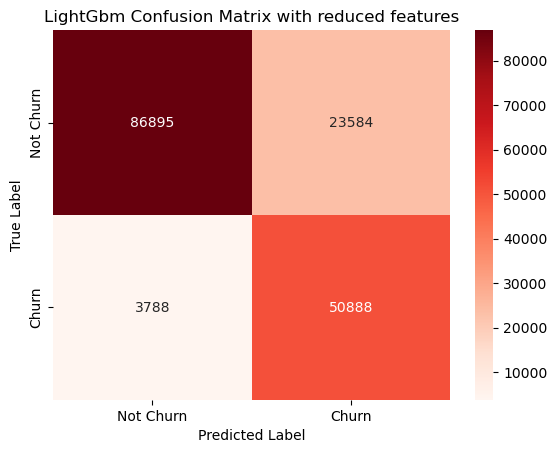

In [259]:
cm_lgb = confusion_matrix(y_test, r_lgb_y_test_pred)  
sns.heatmap(cm_lgb, annot=True, fmt="d", cmap="Reds", xticklabels=["Not Churn", "Churn"], yticklabels=["Not Churn", "Churn"])
plt.title("LightGbm Confusion Matrix with reduced features")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

              precision    recall  f1-score   support

       False       0.84      0.78      0.81    110479
        True       0.61      0.69      0.65     54676

    accuracy                           0.75    165155
   macro avg       0.72      0.73      0.73    165155
weighted avg       0.76      0.75      0.75    165155

ROC-AUC Score Catboost: 0.7342878548179255


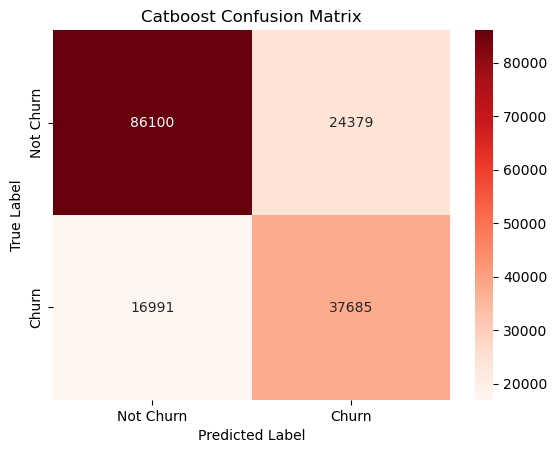

In [260]:
print(classification_report(y_test, ctb_y_test_pred))
roc_auc = roc_auc_score(y_test, ctb_y_test_pred)
print("ROC-AUC Score Catboost:", roc_auc)

cm_ctb = confusion_matrix(y_test, ctb_y_test_pred)  
sns.heatmap(cm_ctb, annot=True, fmt="d", cmap="Reds", xticklabels=["Not Churn", "Churn"], yticklabels=["Not Churn", "Churn"])
plt.title("Catboost Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

##### Lightgbm with reduced features performed better so that's the model that i will be using 

###### My main goal is to target customers likely to churn, so i'll adjust the probability threshold to increase the True recall 

              precision    recall  f1-score   support

       False       0.96      0.76      0.85    110479
        True       0.66      0.94      0.78     54676

    accuracy                           0.82    165155
   macro avg       0.81      0.85      0.81    165155
weighted avg       0.86      0.82      0.83    165155

ROC-AUC Score Lightgbm with increased True recall: 0.8518988904110028


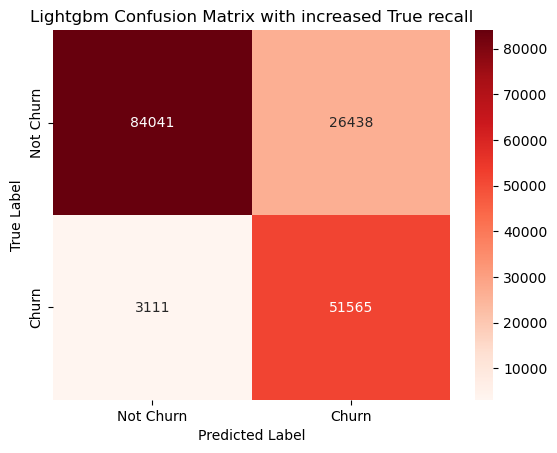

In [263]:
y_pred_proba_lgb = lgb_model_r.predict_proba(lgb_X_test)[:, 1]  
threshold = 0.35  
y_pred_adjusted = (y_pred_proba_lgb >= threshold).astype(int)
# Evaluating the new predictions
print(classification_report(y_test, y_pred_adjusted))
roc_auc = roc_auc_score(y_test, y_pred_adjusted)
print("ROC-AUC Score Lightgbm with increased True recall:", roc_auc)

cm_xgb_recall = confusion_matrix(y_test, y_pred_adjusted)  
sns.heatmap(cm_xgb_recall, annot=True, fmt="d", cmap="Reds", xticklabels=["Not Churn", "Churn"], yticklabels=["Not Churn", "Churn"])
plt.title("Lightgbm Confusion Matrix with increased True recall")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Deploying the model

In [265]:
import joblib

In [266]:
# Saving LightGBM model in my local directory
joblib.dump(lgb_model_r, 'lightgbm_churn_model.pkl')
print("Model saved successfully!")

Model saved successfully!


In [267]:
feature_importance = pd.DataFrame({
    'Feature': lgb_model_r.feature_name_,
    'Importance': lgb_model_r.feature_importances_
})
# Save to CSV
feature_importance.to_csv('feature_importance.csv', index=False)
print("Feature importances saved to feature_importance.csv")

Feature importances saved to feature_importance.csv


In [268]:
test_data_main[:5]

,customer_id,interest_rate,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,...,churn,xgb_churn_prediction,reduced_xgb_churn_prediction,tuned_xgb_churn_prediction,rf_churn_prediction,reduced_rf_churn_prediction,tuned_rf_churn_prediction,lgb_churn_prediction,r_lgb_churn_prediction,ctb_churn_prediction
0,1,0.000000,0,0,14,8,1,3,996.963317,262.299532,...,False,0,0,0,True,True,True,True,True,True
1,2,2.800000,0,0,15,4,35,12,83.379170,80.554303,...,False,1,0,0,True,False,False,True,True,False
2,3,0.000000,0,0,15165,4810,276,13,184368.876268,144343.679163,...,True,1,1,1,True,True,True,True,True,True
3,4,3.200000,0,0,10,8,4,7,417.498012,52.480686,...,True,1,1,1,True,True,True,True,True,True
4,5,3.166667,0,0,1460,6,3,3,9760.154773,1416.894808,...,True,1,1,1,True,True,True,True,True,True


In [446]:
test_data_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165155 entries, 0 to 165154
Data columns (total 34 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   customer_id                   165155 non-null  int64  
 1   interest_rate                 165155 non-null  float64
 2   atm_transfer_in               165155 non-null  int64  
 3   atm_transfer_out              165155 non-null  int64  
 4   bank_transfer_in              165155 non-null  int64  
 5   bank_transfer_out             165155 non-null  int64  
 6   crypto_in                     165155 non-null  int64  
 7   crypto_out                    165155 non-null  int64  
 8   bank_transfer_in_volume       165155 non-null  float64
 9   bank_transfer_out_volume      165155 non-null  float64
 10  crypto_in_volume              165155 non-null  float64
 11  crypto_out_volume             165155 non-null  float64
 12  complaints                    165155 non-nul

In [448]:
my_final_data = pd.concat([test_data_main, customer_test_data['date'].reset_index(drop = True)], axis = 1)

In [450]:
my_final_data[:5]

,customer_id,interest_rate,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,...,xgb_churn_prediction,reduced_xgb_churn_prediction,tuned_xgb_churn_prediction,rf_churn_prediction,reduced_rf_churn_prediction,tuned_rf_churn_prediction,lgb_churn_prediction,r_lgb_churn_prediction,ctb_churn_prediction,date
0,1,0.000000,0,0,14,8,1,3,996.963317,262.299532,...,0,0,0,True,True,True,True,True,True,2026-02-27
1,2,2.800000,0,0,15,4,35,12,83.379170,80.554303,...,1,0,0,True,False,False,True,True,False,2026-01-03
2,3,0.000000,0,0,15165,4810,276,13,184368.876268,144343.679163,...,1,1,1,True,True,True,True,True,True,2024-10-27
3,4,3.200000,0,0,10,8,4,7,417.498012,52.480686,...,1,1,1,True,True,True,True,True,True,2025-02-22
4,5,3.166667,0,0,1460,6,3,3,9760.154773,1416.894808,...,1,1,1,True,True,True,True,True,True,2025-02-11


In [460]:
my_final_data.to_csv('my_final_data.csv', index =False)
print('my final data saved ')

my final data saved 
